# Agent Evaluation for Customer Support: Comparing Models and Parameters

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/gemini/evaluation/synthetic-data-evals/run.ipynb">
      <img width="32px" src="https://www.gstatic.com/pantheon/images/bigquery/welcome_page/colab-logo.svg" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fgenerative-ai%2Fmain%2Fgemini%2Fevaluation%2Fsynthetic-data-evals%2Frun.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/evaluation/synthetic-data-evals/run.ipynb">
      <img src="https://www.gstatic.com/images/branding/gcpiconscolors/vertexai/v1/32px.svg" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/evaluation/synthetic-data-evals/run.ipynb">
      <img width="32px" src="https://raw.githubusercontent.com/primer/octicons/refs/heads/main/icons/mark-github-24.svg" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>

<div style="clear: both;"></div>

<b>Share to:</b>

<a href="https://www.linkedin.com/sharing/share-offsite/?url=https%3A//github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/evaluation/synthetic-data-evals/run.ipynb" target="_blank">
  <img width="20px" src="https://upload.wikimedia.org/wikipedia/commons/8/81/LinkedIn_icon.svg" alt="LinkedIn logo">
</a>

<a href="https://bsky.app/intent/compose?text=https%3A//github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/evaluation/synthetic-data-evals/run.ipynb" target="_blank">
  <img width="20px" src="https://upload.wikimedia.org/wikipedia/commons/7/7a/Bluesky_Logo.svg" alt="Bluesky logo">
</a>

<a href="https://twitter.com/intent/tweet?url=https%3A//github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/evaluation/synthetic-data-evals/run.ipynb" target="_blank">
  <img width="20px" src="https://upload.wikimedia.org/wikipedia/commons/5/5a/X_icon_2.svg" alt="X logo">
</a>

<a href="https://reddit.com/submit?url=https%3A//github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/evaluation/synthetic-data-evals/run.ipynb" target="_blank">
  <img width="20px" src="https://redditinc.com/hubfs/Reddit%20Inc/Brand/Reddit_Logo.png" alt="Reddit logo">
</a>

<a href="https://www.facebook.com/sharer/sharer.php?u=https%3A//github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/evaluation/synthetic-data-evals/run.ipynb" target="_blank">
  <img width="20px" src="https://upload.wikimedia.org/wikipedia/commons/5/51/Facebook_f_logo_%282019%29.svg" alt="Facebook logo">
</a>

| | |
|-|-|
| Authors | [Anish Shah](https://github.com/ash0ts) |

## Overview

This notebook demonstrates how to generate synthetic evaluation data and compare different models and parameters for a customer support agent. We'll explore three main types of evaluations:

1. Final Response Evaluation: Assessing the agent's final answer
2. Single Step Evaluation: Evaluating individual tool selections
3. Trajectory Evaluation: Analyzing the complete path of actions

The tutorial uses the following Google Cloud services and resources:
* [Vertex AI Gen AI Evaluation](https://cloud.google.com/vertex-ai/generative-ai/docs/models/evaluation-overview)
* [Weights and Biases Weave](https://wandb.me/tryweave)

The steps performed include:
* Generating synthetic evaluation data
* Setting up evaluation metrics
* Comparing model performance
* Analyzing evaluation results

**NOTE:** Please run the `setup.py` script in this folder before running the notebook.

In [1]:
IN_COLAB = False
try:
    pass

    IN_COLAB = True
    !git clone https://github.com/ash0ts/generative-ai.git
    %cd generative-ai/gemini/evaluation/synthetic-data-evals
    !pip install -qqq uv
    !uv pip install --system --requirements pyproject.toml
except:
    pass

In [2]:
from set_env import set_env

set_env("GEMINI_API_KEY")
# set_env("HUGGING_FACE_HUB_TOKEN")
set_env("VERTEX_PROJECT_ID")
set_env("VERTEX_LOCATION")
set_env("VERTEX_MODEL_ID")
set_env("VERTEX_ENDPOINT_ID")
# set_env("DEEPSEEK_ENDPOINT_ID")
print("Set API Keys")

Set API Keys


In [3]:
import os
from typing import Any

from config import WEAVE_PROJECT_NAME
from customer_support_agent import create_customer_support_agent
from dataset_generator import (
    DatasetGenerator,
    create_customer_support_agent_evaluation_dataset,
)

# Import our modules
from evaluator import AgentEvaluator, load_dataset
from render_evals import (
    render_conclusion,
    render_difficulty_analysis,
    render_model_comparison,
    render_temperature_analysis,
)
from rich.console import Console
import weave

try:
    in_jupyter = True
except ImportError:
    in_jupyter = False
if in_jupyter:
    import nest_asyncio

    nest_asyncio.apply()

# Initialize console for rich output
console = Console()
console.rule("[bold magenta]Agent Evaluation Framework")

# Initialize Weave for experiment tracking
weave.init(WEAVE_PROJECT_NAME)

─────────────────────────────────────────── Agent Evaluation Framework ────────────────────────────────────────────

Logged in as Weights & Biases user: a-sh0ts.
View Weave data at https://wandb.ai/a-sh0ts/agent_evaluation_demo-dry-run/weave


In [4]:
# Define model configurations to test
model_configs = [
    {
        "model_id": "google/gemini-1.5-pro",
        "temperature": 0.2,
        "name": "Gemini Pro (Low Temp)",
    },
    {
        "model_id": "google/gemini-1.5-pro",
        "temperature": 0.7,
        "name": "Gemini Pro (High Temp)",
    },
    {
        "model_id": "google/gemini-2.0-flash-lite",
        "temperature": 0.2,
        "name": "Gemini Flash Lite (Low Temp)",
    },
    {
        "model_id": "google/gemini-2.0-flash-lite",
        "temperature": 0.7,
        "name": "Gemini Flash Lite (High Temp)",
    },
    # Any other Gemini or OSS model from vertex
]

# Customer Support Agent Architecture

This section describes the architecture and implementation of our customer support agent system, which is built using a combination of LLM-powered components and specialized tools.

## Agent Overview

The customer support agent is designed to handle a variety of e-commerce related queries by leveraging:

1. **Foundation Models**: The agent can be powered by different models including Gemini (1.5 Pro, 2.0 Flash, etc.) through Vertex AI.

2. **Specialized Tools**: A collection of purpose-built tools that provide domain-specific functionality:
   - `ProductSearchTool`: Searches the product catalog by name, category, or description
   - `OrderStatusTool`: Checks the status of customer orders
   - `CategoryBrowseTool`: Allows browsing products by category
   - `PriceCheckTool`: Retrieves pricing information for specific products
   - `CustomerOrderHistoryTool`: Retrieves order history for customers

3. **Realistic Data**: The system uses realistic product and order data derived from Amazon reviews to provide a realistic customer support experience.

## Technical Implementation

The implementation consists of two main components:

1. **`customer_support_agent.py`**: Contains the tool implementations and agent creation logic. The `create_customer_support_agent()` function configures the agent with the specified model, temperature, planning capabilities, and tools.

2. **`vertex_model.py`**: Provides the model implementations that connect to Vertex AI:
   - `VertexAIServerModel`: Base implementation for connecting to Vertex AI endpoints
   - `WeaveVertexAIServerModel`: Extends the base model with Weights & Biases Weave tracking for experiment monitoring

## Configuration Options

The agent can be configured with various parameters:
- Model selection (Gemini 1.5 Pro, 2.0 Flash, etc.)
- Temperature settings for controlling response randomness
- Planning interval to determine how often the agent should plan its actions
- Maximum steps to limit the complexity of interactions

This architecture enables comprehensive evaluation of different model configurations and parameters to determine the optimal setup for customer support scenarios.


In [5]:
console.print("[bold blue]Creating customer support agent[/bold blue]")

# Initialize a customer support agent for generating high-quality evaluation data
base_agent = create_customer_support_agent(
    use_weave=True,  # Enable Weave for experiment tracking
    model_id="google/gemini-2.0-flash",  # Use Gemini 2.0 for fast and accurate generation
    temperature=0.1,  # Low temperature for consistent, deterministic outputs
    planning_interval=2,  # Plan every 2 steps for better reasoning
    max_steps=4,  # Allow up to 4 steps to handle medium-complex queries
)

Creating customer support agent

In [6]:
base_agent.run("What is the best item in the category of book?")

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ What is the best item in the category of book?                                                                  │
│                                                                                                                 │
╰─ WeaveVertexAIServerModel - google/gemini-2.0-flash ────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────── Initial plan ───────────────────────────────────────────────────
Here is the plan of action that I will follow to solve the task:
```
1. Browse the 'book' category to get a list of books.
2. Search for product information for each book in the list to gather details like ratings, reviews, and sales 
figures.
3. Analyze the gathered information to determine the "best" book based on a combination of factors such as ratings,
reviews, and sales.
4. Provide the "best" book as the final answer.
\n
```

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  books = category_browse(category='book')                                                                         
  print(books)                                                                                                     
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
{
  "category": "book",
  "product_count": 5,
  "price_range": "$42.84 - $87.96",
  "top_products": [
    {
      "product_id": "product_en_0072152",
      "name": "Digital Ebook Purchase Item 2152",
      "price": "$87.96",
      "stock": 127
    },
    {
      "product_id": "product_en_0061764",
      "name": "Digital Ebook Purchase Item 1764",
      "price": "$66.78",
      "stock": 137
    },
    {
      "product_id": "product_en_0025873",
      "name": "Digital Ebook Purchase Item 5873",
      "price": "$65.58",
      "stock": 90
    },
    {
      "product_id": "product_en_0000782",
      "name": "Book Item 0782",
      "price": "$50.01",
      "stock": 92
    },
    {
      "product_id": "product_en_0103332",
      "name": "Digital Ebook Purchase Item 3332",
      "price": "$42.84",
      "stock": 121
    }
  ]
}

Out: None

[Step 1: Duration 6.38 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  product_ids = ['product_en_0072152', 'product_en_0061764', 'product_en_0025873', 'product_en_0000782',           
  'product_en_0103332']                                                                                            
  for product_id in product_ids:                                                                                   
      product_info = product_search(query=product_id)                                                              
      print(product_info)                                                                                          
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
{"error": "Product not found"}
{"error": "Product not found"}
{"error": "Product not found"}
{"error": "Product not found"}
{"error": "Product not found"}

Out: {"error": "Product not found"}

[Step 2: Duration 1.13 seconds]

────────────────────────────────────────────────── Updated plan ───────────────────────────────────────────────────
I still need to solve the task I was given:
```
What is the best item in the category of book?
```

Here is my new/updated plan of action to solve the task:
```
1. Define "best" in the context of books (e.g., based on reviews, sales, awards).
2. Search for product information for each book in the list obtained earlier, using the book names as the search 
query.
3. Analyze the gathered information to determine the "best" book based on the defined criteria.
4. Provide the "best" book as the final answer.
\n
```

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  book_names = ["Digital Ebook Purchase Item 2152", "Digital Ebook Purchase Item 1764", "Digital Ebook Purchase    
  Item 5873", "Book Item 0782", "Digital Ebook Purchase Item 3332"]                                                
  for book_name in book_names:                                                                                     
      product_info = product_search(query=book_name)                                                               
      print(product_info)                                                                                          
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
[
  {
    "product_id": "product_en_0072152",
    "name": "Digital Ebook Purchase Item 2152",
    "category": "digital_ebook_purchase",
    "price": "$87.96",
    "stock": 127,
    "description": "Quality digital ebook purchase product with ID 2152.",
    "warranty": "1 year limited",
    "return_period": "14 days"
  }
]
[
  {
    "product_id": "product_en_0061764",
    "name": "Digital Ebook Purchase Item 1764",
    "category": "digital_ebook_purchase",
    "price": "$66.78",
    "stock": 137,
    "description": "Quality digital ebook purchase product with ID 1764.",
    "warranty": "1 year limited",
    "return_period": "14 days"
  }
]
[
  {
    "product_id": "product_en_0025873",
    "name": "Digital Ebook Purchase Item 5873",
    "category": "digital_ebook_purchase",
    "price": "$65.58",
    "stock": 90,
    "description": "Quality digital ebook purchase product with ID 5873.",
    "warranty": "1 year limited",
    "return_period": "14 days"
  }
]
[
  {
    "product_id": "product_en_0000782",
    "name": "Book Item 0782",
    "category": "book",
    "price": "$50.01",
    "stock": 92,
    "description": "Quality book product with ID 0782.",
    "warranty": "1 year limited",
    "return_period": "14 days"
  }
]
[
  {
    "product_id": "product_en_0103332",
    "name": "Digital Ebook Purchase Item 3332",
    "category": "digital_ebook_purchase",
    "price": "$42.84",
    "stock": 121,
    "description": "Quality digital ebook purchase product with ID 3332.",
    "warranty": "90 days",
    "return_period": "7 days"
  }
]

Out: [
  {
    "product_id": "product_en_0103332",
    "name": "Digital Ebook Purchase Item 3332",
    "category": "digital_ebook_purchase",
    "price": "$42.84",
    "stock": 121,
    "description": "Quality digital ebook purchase product with ID 3332.",
    "warranty": "90 days",
    "return_period": "7 days"
  }
]

[Step 3: Duration 5.44 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 4 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  book_data = [                                                                                                    
      {"product_id": "product_en_0072152", "name": "Digital Ebook Purchase Item 2152", "price": 87.96},            
      {"product_id": "product_en_0061764", "name": "Digital Ebook Purchase Item 1764", "price": 66.78},            
      {"product_id": "product_en_0025873", "name": "Digital Ebook Purchase Item 5873", "price": 65.58},            
      {"product_id": "product_en_0000782", "name": "Book Item 0782", "price": 50.01},                              
      {"product_id": "product_en_0103332", "name": "Digital Ebook Purchase Item 3332", "price": 42.84}             
  ]                                                                                                                
                                                                                                                   
  best_book = max(book_data, key=lambda x: x["price"])                                                             
  print(best_book)                                                                                                 
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
{'product_id': 'product_en_0072152', 'name': 'Digital Ebook Purchase Item 2152', 'price': 87.96}

Out: None

[Step 4: Duration 1.95 seconds]

Reached max steps.

[Step 5: Duration 2.45 seconds]

'The best item in the category of book is Digital Ebook Purchase Item 2152.\n'

# Synthetic Dataset Generation for Agent Evaluation

This section explains how we generate realistic test data to evaluate our customer support agent across different configurations and scenarios.

## Why We Need Synthetic Evaluation Data

Testing with synthetic data helps us:

1. **Compare Models Fairly**: We can test different models (Gemini Pro vs Flash) and settings (temperature values) on the exact same customer queries.

2. **Save Time and Resources**: Creating test data is faster and cheaper than collecting real customer conversations.

3. **Cover Edge Cases**: We can include challenging scenarios that might be rare in real data but important to test.

4. **Ensure Consistent Quality**: By filtering examples that meet quality thresholds, we build a reliable benchmark dataset.

## How the Dataset Generator Works

The `DatasetGenerator` class creates evaluation data through several steps:

1. **Creating Realistic Queries**: Generates e-commerce questions using real product IDs, categories, and customer information:
   - "I'm looking for products in the Books category. What do you have?"
   - "Can you check the status of my order OD123456?"
   - "What's your best Electronics product? I need something reliable."

2. **Recording Agent Behavior**: Runs the agent on these queries and captures:
   - Which tools the agent used (ProductSearch, OrderStatus, etc.)
   - The arguments passed to each tool
   - The agent's reasoning at each step
   - The final response to the user

3. **Evaluating Quality**: Uses a judge model to score:
   - Final response quality (0-1 score)
   - Individual step effectiveness (0-1 score per step)
   - Overall trajectory coherence (0-1 score)

4. **Filtering Results**: Only keeps examples that meet quality thresholds (typically 0.7 for each dimension).

## Dataset Structure and Applications

Each example in the final dataset includes:
- The original user prompt
- Expected tool usage sequence
- Validation criteria
- Difficulty rating (easy, medium, hard)
- Metadata about model configuration

This dataset lets us:
1. Determine which model performs best for customer support
2. Find the right temperature settings for different query types
3. Measure whether planning capabilities improve results
4. Identify specific areas where the agent needs improvement

By testing systematically, we can build a more effective customer support agent that handles user queries accurately while using computational resources efficiently.


In [7]:
# Initialize dataset generator
thresholds = {"final_response": 0.7, "single_step": 0.7, "trajectory": 0.7}
generator = DatasetGenerator(agent=base_agent, thresholds=thresholds, debug=True)

# Generate comprehensive dataset with different scenarios
console.print(
    "[bold blue]Generating customer support evaluation dataset...[/bold blue]"
)

dataset = create_customer_support_agent_evaluation_dataset(
    generator, base_agent, num_prompts=5
)  # Adjust number as needed

# Save generated dataset
dataset_path = "customer_support_eval.json"
generator.save_dataset(dataset, dataset_path)

console.print(f"[green]✓[/green] Dataset generation complete! Saved to {dataset_path}")

Initialized with thresholds:

final_response: 0.7

single_step: 0.7

trajectory: 0.7

Generating customer support evaluation dataset...

─────────────────────────────── Creating Customer Support Agent Evaluation Dataset ────────────────────────────────

Agent model: WeaveVertexAIServerModel

Available tools: ['product_search', 'order_status', 'category_browse', 'price_check', 'customer_order_history', 
'final_answer']

────────────────────────────────────────── Generating E-commerce Prompts ──────────────────────────────────────────

Loaded 100 products and 200 orders

Sample product IDs: ['product_en_0065235', 'product_en_0062384', 'product_en_0036574']

Sample categories: ['shoes', 'pc', 'lawn_and_garden']

Generated 5 e-commerce prompts

Sample 1: I'm looking for products in the shoes category. What do you have?

Sample 2: Can you check the status of my order OD179190?

Sample 3: How much does product product_en_0065235 cost?

Sample 4: Can you show me my recent orders? My customer ID is reviewer_en_0048495

Sample 5: I'm looking for pc products and also want to check my order OD471296

────────────────────────────────────────────── Processing Prompt 1/5 ──────────────────────────────────────────────

────────────────────────────────────────────────── Running Agent ──────────────────────────────────────────────────

Prompt: I'm looking for products in the shoes category. What do you have?

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ I'm looking for products in the shoes category. What do you have?                                               │
│                                                                                                                 │
╰─ WeaveVertexAIServerModel - google/gemini-2.0-flash ────────────────────────────────────────────────────────────╯

This agent has step_callbacks: they will be ignored by this method. 1

This agent has step_callbacks: they will be ignored by this method. 1

────────────────────────────────────────────────── Initial plan ───────────────────────────────────────────────────
Here is the plan of action that I will follow to solve the task:
```
1. Browse the products by the category "shoes" using the `category_browse` tool.
2. Formulate a final answer based on the results from the `category_browse` tool.
3. Respond to the user with the final answer using the `final_answer` tool.


```

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  shoes_products = category_browse(category="shoes")                                                               
  final_answer(shoes_products)                                                                                     
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: {
  "category": "shoes",
  "product_count": 1,
  "price_range": "$54.11 - $54.11",
  "top_products": [
    {
      "product_id": "product_en_0090440",
      "name": "Shoes Item 0440",
      "price": "$54.11",
      "stock": 73
    }
  ]
}

[Step 1: Duration 2.97 seconds]

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Step 1:                                                                                                         │
│ Tool: python_interpreter                                                                                        │
│ Args: shoes_products = category_browse(category="shoes")                                                        │
│ final_answer(shoes_products)                                                                                    │
│ Output: {                                                                                                       │
│   "category": "shoes",                                                                                          │
│   "product_count": 1,                                                                                           │
│   "price_range": "$54.11 - $54.11",                                                                             │
│   "top_products": [                                                                                             │
│     {                                                                                                           │
│       "product_id": "product_en_0090440",                                                                       │
│       "name": "Shoes Item 0440",                                                                                │
│       "price": "$54.11",                                                                                        │
│       "stock": 73                                                                                               │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Final Response: {
  "category": "shoes",
  "product_count": 1,
  "price_range": "$54.11 - $54.11",
  "top_products": [
    {
      "product_id": "product_en_0090440",
      "name": "Shoes Item 0440",
      "price": "$54.11",
      "stock": 73
    }
  ]
}

Collecting Scores...

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Code Analysis                                                                                                   │
│ Code:                                                                                                           │
│ shoes_products = category_browse(category="shoes")                                                              │
│ final_answer(shoes_products)                                                                                    │
│ Tools Found: ['category_browse', 'final_answer']                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

───────────────────────────────────────────── Judging Final Response ──────────────────────────────────────────────

Final Response Score: 1.00

Reasoning: Correct category, product count, price range, and product information are returned. Appropriate tools 
are used. The response is clearly communicated.

────────────────────────────────────────────────── Judging Step ───────────────────────────────────────────────────

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Code Analysis                                                                                                   │
│ Code:                                                                                                           │
│ shoes_products = category_browse(category="shoes")                                                              │
│ final_answer(shoes_products)                                                                                    │
│ Tools Found: ['category_browse', 'final_answer']                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Tools Used: ['category_browse', 'final_answer']

Score: 1.00

Reasoning: The agent correctly uses the category_browse tool to fetch products in the "shoes" category and then 
presents them to the user using final_answer. The reasoning and code are accurate, directly addressing the user's 
prompt.

─────────────────────────────────────────────── Judging Trajectory ────────────────────────────────────────────────

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Code Analysis                                                                                                   │
│ Code:                                                                                                           │
│ shoes_products = category_browse(category="shoes")                                                              │
│ final_answer(shoes_products)                                                                                    │
│ Tools Found: ['category_browse', 'final_answer']                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Step 1 Tools: ['category_browse', 'final_answer']

Trajectory Score: 1.00

Reasoning: The agent correctly uses the `category_browse` tool with the "shoes" category and then the 
`final_answer` tool to display the results. The response is comprehensive and includes product count, price range, 
and top product details. The code is efficient and directly addresses the user prompt.

                                                 Evaluation Scores                                                 
┏━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric         ┃ Score ┃ Reasoning                                                                              ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Final Response │ 1.00  │ Correct category, product count, price range, and product information are returned.    │
│                │       │ Appropriate tools are used. The response is clearly communicated.                      │
│ Trajectory     │ 1.00  │ The agent correctly uses the `category_browse` tool with the "shoes" category and then │
│                │       │ the `final_answer` tool to display the results. The response is comprehensive and      │
│                │       │ includes product count, price range, and top product details. The code is efficient    │
│                │       │ and directly addresses the user prompt.                                                │
│ Step Scores    │ 1.00  │ The agent correctly uses the category_browse tool to fetch products in the "shoes"     │
│                │       │ category and then presents them to the user using final_answer. The reasoning and code │
│                │       │ are accurate, directly addressing the user's prompt.                                   │
└────────────────┴───────┴────────────────────────────────────────────────────────────────────────────────────────┘

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Code Analysis                                                                                                   │
│ Code:                                                                                                           │
│ shoes_products = category_browse(category="shoes")                                                              │
│ final_answer(shoes_products)                                                                                    │
│ Tools Found: ['category_browse', 'final_answer']                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Run Summary                                                                                                     │
│ Steps: 1                                                                                                        │
│ Tools Used: ['category_browse', 'final_answer']                                                                 │
│ Planning: Enabled                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────── Processing Prompt 2/5 ──────────────────────────────────────────────

────────────────────────────────────────────────── Running Agent ──────────────────────────────────────────────────

Prompt: Can you check the status of my order OD179190?

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Can you check the status of my order OD179190?                                                                  │
│                                                                                                                 │
╰─ WeaveVertexAIServerModel - google/gemini-2.0-flash ────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────── Initial plan ───────────────────────────────────────────────────
Here is the plan of action that I will follow to solve the task:
```
1. Use the `order_status` tool to check the status of the order with ID OD179190.
2. Use the `final_answer` tool to provide the order status to the user.
\

```

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  order_id = "OD179190"                                                                                            
  order_information = order_status(order_id=order_id)                                                              
  print(order_information)                                                                                         
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
{
  "order_id": "OD179190",
  "customer_id": "reviewer_en_0852181",
  "product_id": "product_en_0715785",
  "status": "processing",
  "order_date": "2025-02-19",
  "delivery_date": NaN,
  "estimated_delivery_date": "2025-02-22",
  "tracking_number": NaN,
  "delivery_estimate": "2025-02-22"
}

Out: None

[Step 1: Duration 5.01 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  order_status_information = "The order status is processing, and the estimated delivery date is 2025-02-22."      
  final_answer(order_status_information)                                                                           
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: The order status is processing, and the estimated delivery date is 2025-02-22.

[Step 2: Duration 0.98 seconds]

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Step 1:                                                                                                         │
│ Tool: python_interpreter                                                                                        │
│ Args: order_id = "OD179190"                                                                                     │
│ order_information = order_status(order_id=order_id)                                                             │
│ print(order_information)                                                                                        │
│ Output: None                                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Step 2:                                                                                                         │
│ Tool: python_interpreter                                                                                        │
│ Args: order_status_information = "The order status is processing, and the estimated delivery date is            │
│ 2025-02-22."                                                                                                    │
│ final_answer(order_status_information)                                                                          │
│ Output: The order status is processing, and the estimated delivery date is 2025-02-22.                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Final Response: The order status is processing, and the estimated delivery date is 2025-02-22.

Collecting Scores...

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Code Analysis                                                                                                   │
│ Code:                                                                                                           │
│ order_id = "OD179190"                                                                                           │
│ order_information = order_status(order_id=order_id)                                                             │
│ print(order_information)                                                                                        │
│ Tools Found: ['order_status']                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Code Analysis                                                                                                   │
│ Code:                                                                                                           │
│ order_status_information = "The order status is processing, and the estimated delivery date is 2025-02-22."     │
│ final_answer(order_status_information)                                                                          │
│ Tools Found: ['order_status', 'final_answer']                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

───────────────────────────────────────────── Judging Final Response ──────────────────────────────────────────────

Final Response Score: 1.00

Reasoning: The agent successfully used the available tools to respond to the user query accurately and completely. 
The response is also easy to understand.

────────────────────────────────────────────────── Judging Step ───────────────────────────────────────────────────

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Code Analysis                                                                                                   │
│ Code:                                                                                                           │
│ order_id = "OD179190"                                                                                           │
│ order_information = order_status(order_id=order_id)                                                             │
│ print(order_information)                                                                                        │
│ Tools Found: ['order_status']                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Tools Used: ['order_status']

Score: 1.00

Reasoning: The agent correctly used the `order_status` tool to retrieve the order information for the provided 
order ID. The reasoning and code are clear and directly address the user's prompt.  This is a good first step 
towards providing the user with the order status.

────────────────────────────────────────────────── Judging Step ───────────────────────────────────────────────────

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Code Analysis                                                                                                   │
│ Code:                                                                                                           │
│ order_status_information = "The order status is processing, and the estimated delivery date is 2025-02-22."     │
│ final_answer(order_status_information)                                                                          │
│ Tools Found: ['order_status', 'final_answer']                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Tools Used: ['order_status', 'final_answer']

Score: 1.00

Reasoning: The agent correctly used the available information and tools to respond to the user prompt. The 
reasoning and code are accurate and appropriate. The response is also easy to understand.

─────────────────────────────────────────────── Judging Trajectory ────────────────────────────────────────────────

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Code Analysis                                                                                                   │
│ Code:                                                                                                           │
│ order_id = "OD179190"                                                                                           │
│ order_information = order_status(order_id=order_id)                                                             │
│ print(order_information)                                                                                        │
│ Tools Found: ['order_status']                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Step 1 Tools: ['order_status']

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Code Analysis                                                                                                   │
│ Code:                                                                                                           │
│ order_status_information = "The order status is processing, and the estimated delivery date is 2025-02-22."     │
│ final_answer(order_status_information)                                                                          │
│ Tools Found: ['order_status', 'final_answer']                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Step 2 Tools: ['order_status', 'final_answer']

Trajectory Score: 1.00

Reasoning: The agent correctly used the available tools to find the order status and return it to the user. The 
agent first used the `order_status` tool with the correct order ID, then used the `final_answer` tool to give the 
information back to the user.

                                                 Evaluation Scores                                                 
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric         ┃ Score      ┃ Reasoning                                                                         ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Final Response │ 1.00       │ The agent successfully used the available tools to respond to the user query      │
│                │            │ accurately and completely. The response is also easy to understand.               │
│ Trajectory     │ 1.00       │ The agent correctly used the available tools to find the order status and return  │
│                │            │ it to the user. The agent first used the `order_status` tool with the correct     │
│                │            │ order ID, then used the `final_answer` tool to give the information back to the   │
│                │            │ user.                                                                             │
│ Step Scores    │ 1.00, 1.00 │ The agent correctly used the `order_status` tool to retrieve the order            │
│                │            │ information for the provided order ID. The reasoning and code are clear and       │
│                │            │ directly address the user's prompt.  This is a good first step towards providing  │
│                │            │ the user with the order status.                                                   │
│                │            │ The agent correctly used the available information and tools to respond to the    │
│                │            │ user prompt. The reasoning and code are accurate and appropriate. The response is │
│                │            │ also easy to understand.                                                          │
└────────────────┴────────────┴───────────────────────────────────────────────────────────────────────────────────┘

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Code Analysis                                                                                                   │
│ Code:                                                                                                           │
│ order_id = "OD179190"                                                                                           │
│ order_information = order_status(order_id=order_id)                                                             │
│ print(order_information)                                                                                        │
│ Tools Found: ['order_status']                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Code Analysis                                                                                                   │
│ Code:                                                                                                           │
│ order_status_information = "The order status is processing, and the estimated delivery date is 2025-02-22."     │
│ final_answer(order_status_information)                                                                          │
│ Tools Found: ['order_status', 'final_answer']                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Run Summary                                                                                                     │
│ Steps: 2                                                                                                        │
│ Tools Used: ['order_status', 'final_answer']                                                                    │
│ Planning: Enabled                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────── Processing Prompt 3/5 ──────────────────────────────────────────────

────────────────────────────────────────────────── Running Agent ──────────────────────────────────────────────────

Prompt: How much does product product_en_0065235 cost?

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ How much does product product_en_0065235 cost?                                                                  │
│                                                                                                                 │
╰─ WeaveVertexAIServerModel - google/gemini-2.0-flash ────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────── Initial plan ───────────────────────────────────────────────────
Here is the plan of action that I will follow to solve the task:
```
1. Use the `price_check` tool to find the price of the product with ID `product_en_0065235`.
2. Use the `final_answer` tool to provide the price obtained in the previous step as the answer.


```

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  product_id = "product_en_0065235"                                                                                
  price = price_check(product_id=product_id)                                                                       
  print(price)                                                                                                     
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Code execution failed at line 'price = price_check(product_id=product_id)' due to: TypeError: Object of type bool 
is not JSON serializable

[Step 1: Duration 2.55 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  product_id = "product_en_0065235"                                                                                
  try:                                                                                                             
      price = price_check(product_id=product_id)                                                                   
      print(price)                                                                                                 
  except Exception as e:                                                                                           
      print(f"Error checking price: {e}")                                                                          
      price = "Product not found or error occurred"                                                                
  final_answer(price)                                                                                              
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
Error checking price: Object of type bool is not JSON serializable

Out - Final answer: Product not found or error occurred

[Step 2: Duration 1.12 seconds]

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Step 1:                                                                                                         │
│ Tool: python_interpreter                                                                                        │
│ Args: product_id = "product_en_0065235"                                                                         │
│ price = price_check(product_id=product_id)                                                                      │
│ print(price)                                                                                                    │
│ Output: None                                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Step 2:                                                                                                         │
│ Tool: python_interpreter                                                                                        │
│ Args: product_id = "product_en_0065235"                                                                         │
│ try:                                                                                                            │
│     price = price_check(product_id=product_id)                                                                  │
│     print(price)                                                                                                │
│ except Exception as e:                                                                                          │
│     print(f"Error checking price: {e}")                                                                         │
│     price = "Product not found or error occurred"                                                               │
│ final_answer(price)                                                                                             │
│ Output: Product not found or error occurred                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Final Response: Product not found or error occurred

Collecting Scores...

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Code Analysis                                                                                                   │
│ Code:                                                                                                           │
│ product_id = "product_en_0065235"                                                                               │
│ price = price_check(product_id=product_id)                                                                      │
│ print(price)                                                                                                    │
│ Tools Found: ['price_check']                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Code Analysis                                                                                                   │
│ Code:                                                                                                           │
│ product_id = "product_en_0065235"                                                                               │
│ try:                                                                                                            │
│     price = price_check(product_id=product_id)                                                                  │
│     print(price)                                                                                                │
│ except Exception as e:                                                                                          │
│     print(f"Error checking price: {e}")                                                                         │
│     price = "Product not found or error occurred"                                                               │
│ final_answer(price)                                                                                             │
│ Tools Found: ['price_check', 'final_answer']                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

───────────────────────────────────────────── Judging Final Response ──────────────────────────────────────────────

Final Response Score: 0.30

Reasoning: Although the tool usage was appropriate, the final answer was incorrect. It should have returned a 
price. The response was also not very informative.

────────────────────────────────────────────────── Judging Step ───────────────────────────────────────────────────

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Code Analysis                                                                                                   │
│ Code:                                                                                                           │
│ product_id = "product_en_0065235"                                                                               │
│ price = price_check(product_id=product_id)                                                                      │
│ print(price)                                                                                                    │
│ Tools Found: ['price_check']                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Tools Used: ['price_check']

Score: 1.00

Reasoning: The agent correctly used the available tool and the appropriate arguments to check the price. The 
reasoning is sound and effective.

────────────────────────────────────────────────── Judging Step ───────────────────────────────────────────────────

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Code Analysis                                                                                                   │
│ Code:                                                                                                           │
│ product_id = "product_en_0065235"                                                                               │
│ try:                                                                                                            │
│     price = price_check(product_id=product_id)                                                                  │
│     print(price)                                                                                                │
│ except Exception as e:                                                                                          │
│     print(f"Error checking price: {e}")                                                                         │
│     price = "Product not found or error occurred"                                                               │
│ final_answer(price)                                                                                             │
│ Tools Found: ['price_check', 'final_answer']                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Tools Used: ['price_check', 'final_answer']

Score: 1.00

Reasoning: The agent correctly attempts to check the price using the available tool and implements reasonable error
handling. The reasoning is sound and the code is appropriate. It makes good progress toward answering the user's 
question, although the final answer will depend on the actual price returned by the tool or the handling of the 
error if the product is not found.  The step is clear and effective.

─────────────────────────────────────────────── Judging Trajectory ────────────────────────────────────────────────

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Code Analysis                                                                                                   │
│ Code:                                                                                                           │
│ product_id = "product_en_0065235"                                                                               │
│ price = price_check(product_id=product_id)                                                                      │
│ print(price)                                                                                                    │
│ Tools Found: ['price_check']                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Step 1 Tools: ['price_check']

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Code Analysis                                                                                                   │
│ Code:                                                                                                           │
│ product_id = "product_en_0065235"                                                                               │
│ try:                                                                                                            │
│     price = price_check(product_id=product_id)                                                                  │
│     print(price)                                                                                                │
│ except Exception as e:                                                                                          │
│     print(f"Error checking price: {e}")                                                                         │
│     price = "Product not found or error occurred"                                                               │
│ final_answer(price)                                                                                             │
│ Tools Found: ['price_check', 'final_answer']                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Step 2 Tools: ['price_check', 'final_answer']

Trajectory Score: 0.40

Reasoning: The agent attempts to use the correct tool and inputs the correct product ID. Initially, the agent does 
not account for errors in the tool. The agent then recognizes the error and attempts to fix it. However, the 
response is a canned response that does not reflect the actual error. The agent should also have checked the price 
before declaring that it could not find the product or an error had occurred. The agent ultimately returns a canned
response, which is a suboptimal response. A slightly better response would have been to simply output the error. 
The agent should also have attempted to check the price before outputting an error. Thus, I am giving this a 
slightly below average score.

Final response score 0.30 below threshold 0.7

────────────────────────────────────────────── Processing Prompt 4/5 ──────────────────────────────────────────────

────────────────────────────────────────────────── Running Agent ──────────────────────────────────────────────────

Prompt: Can you show me my recent orders? My customer ID is reviewer_en_0048495

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Can you show me my recent orders? My customer ID is reviewer_en_0048495                                         │
│                                                                                                                 │
╰─ WeaveVertexAIServerModel - google/gemini-2.0-flash ────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────── Initial plan ───────────────────────────────────────────────────
Here is the plan of action that I will follow to solve the task:
```
1. Use the `customer_order_history` tool to retrieve the order history for the customer with ID 
"reviewer_en_0048495".
2. Use the `final_answer` tool to present the retrieved order history to the user.


```

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  customer_id = "reviewer_en_0048495"                                                                              
  order_history = customer_order_history(customer_id=customer_id)                                                  
  final_answer(order_history)                                                                                      
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: {
  "customer_id": "reviewer_en_0048495",
  "order_count": 1,
  "recent_orders": [
    {
      "order_id": "OD349791",
      "date": "2024-10-24",
      "status": "delivered",
      "product_id": "product_en_0818466",
      "delivery_date": "2024-10-30"
    }
  ]
}

[Step 1: Duration 5.17 seconds]

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Step 1:                                                                                                         │
│ Tool: python_interpreter                                                                                        │
│ Args: customer_id = "reviewer_en_0048495"                                                                       │
│ order_history = customer_order_history(customer_id=customer_id)                                                 │
│ final_answer(order_history)                                                                                     │
│ Output: {                                                                                                       │
│   "customer_id": "reviewer_en_0048495",                                                                         │
│   "order_count": 1,                                                                                             │
│   "recent_orders": [                                                                                            │
│     {                                                                                                           │
│       "order_id": "OD349791",                                                                                   │
│       "date": "2024-10-24",                                                                                     │
│       "status": "delivered",                                                                                    │
│       "product_id": "product_en_0818466",                                                                       │
│       "delivery_date": "2024-10-30"                                                                             │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Final Response: {
  "customer_id": "reviewer_en_0048495",
  "order_count": 1,
  "recent_orders": [
    {
      "order_id": "OD349791",
      "date": "2024-10-24",
      "status": "delivered",
      "product_id": "product_en_0818466",
      "delivery_date": "2024-10-30"
    }
  ]
}

Collecting Scores...

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Code Analysis                                                                                                   │
│ Code:                                                                                                           │
│ customer_id = "reviewer_en_0048495"                                                                             │
│ order_history = customer_order_history(customer_id=customer_id)                                                 │
│ final_answer(order_history)                                                                                     │
│ Tools Found: ['customer_order_history', 'final_answer']                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

───────────────────────────────────────────── Judging Final Response ──────────────────────────────────────────────

Final Response Score: 1.00

Reasoning: Correct answer. Used appropriate tools and communicated the information clearly.

────────────────────────────────────────────────── Judging Step ───────────────────────────────────────────────────

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Code Analysis                                                                                                   │
│ Code:                                                                                                           │
│ customer_id = "reviewer_en_0048495"                                                                             │
│ order_history = customer_order_history(customer_id=customer_id)                                                 │
│ final_answer(order_history)                                                                                     │
│ Tools Found: ['customer_order_history', 'final_answer']                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Tools Used: ['customer_order_history', 'final_answer']

Score: 1.00

Reasoning: The agent correctly interprets the user's request and extracts the customer ID. It then attempts to 
retrieve the order history using the `customer_order_history` tool and provides the result using `final_answer`, 
which is a reasonable approach.  This demonstrates good understanding of the prompt and appropriate tool use. 
Awarding a score of 1.

─────────────────────────────────────────────── Judging Trajectory ────────────────────────────────────────────────

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Code Analysis                                                                                                   │
│ Code:                                                                                                           │
│ customer_id = "reviewer_en_0048495"                                                                             │
│ order_history = customer_order_history(customer_id=customer_id)                                                 │
│ final_answer(order_history)                                                                                     │
│ Tools Found: ['customer_order_history', 'final_answer']                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Step 1 Tools: ['customer_order_history', 'final_answer']

Trajectory Score: 1.00

Reasoning: The agent correctly used the available tools and achieved the desired outcome. The agent correctly 
extracted the customer ID, used the tool to retrieve order history and displayed the result.

                                                 Evaluation Scores                                                 
┏━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric         ┃ Score ┃ Reasoning                                                                              ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Final Response │ 1.00  │ Correct answer. Used appropriate tools and communicated the information clearly.       │
│ Trajectory     │ 1.00  │ The agent correctly used the available tools and achieved the desired outcome. The     │
│                │       │ agent correctly extracted the customer ID, used the tool to retrieve order history and │
│                │       │ displayed the result.                                                                  │
│ Step Scores    │ 1.00  │ The agent correctly interprets the user's request and extracts the customer ID. It     │
│                │       │ then attempts to retrieve the order history using the `customer_order_history` tool    │
│                │       │ and provides the result using `final_answer`, which is a reasonable approach.  This    │
│                │       │ demonstrates good understanding of the prompt and appropriate tool use. Awarding a     │
│                │       │ score of 1.                                                                            │
└────────────────┴───────┴────────────────────────────────────────────────────────────────────────────────────────┘

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Code Analysis                                                                                                   │
│ Code:                                                                                                           │
│ customer_id = "reviewer_en_0048495"                                                                             │
│ order_history = customer_order_history(customer_id=customer_id)                                                 │
│ final_answer(order_history)                                                                                     │
│ Tools Found: ['customer_order_history', 'final_answer']                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Run Summary                                                                                                     │
│ Steps: 1                                                                                                        │
│ Tools Used: ['customer_order_history', 'final_answer']                                                          │
│ Planning: Enabled                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────── Processing Prompt 5/5 ──────────────────────────────────────────────

────────────────────────────────────────────────── Running Agent ──────────────────────────────────────────────────

Prompt: I'm looking for pc products and also want to check my order OD471296

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ I'm looking for pc products and also want to check my order OD471296                                            │
│                                                                                                                 │
╰─ WeaveVertexAIServerModel - google/gemini-2.0-flash ────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────── Initial plan ───────────────────────────────────────────────────
Here is the plan of action that I will follow to solve the task:
```
1. Clarify the type of PC products the user is looking for.
2. Clarify the vendor/company/website where the order OD471296 was placed.
3. Clarify what information the user needs about the order OD471296.
4. Search for the specified PC products using the product_search tool.
5. Check the status of order OD471296 using the order_status tool.
6. Formulate a final answer containing the search results for PC products and the order status.
\n
```

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  print("What kind of PC products are you looking for (e.g., laptops, desktops, components)?")                     
  print("With which vendor/company/website was order OD471296 placed?")                                            
  print("What information do you need about the order OD471296 (e.g., status, tracking, items)?")                  
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
What kind of PC products are you looking for (e.g., laptops, desktops, components)?
With which vendor/company/website was order OD471296 placed?
What information do you need about the order OD471296 (e.g., status, tracking, items)?

Out: None

[Step 1: Duration 5.29 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Error in code parsing:
Your code snippet is invalid, because the regex pattern ```(?:py|python)?\n(.*?)\n``` was not found in it.
Here is your code snippet:
Thought:The user needs to provide more information before I can proceed. I will wait for the user to provide the 
information and then continue with the plan.
```json
{
  "pc_product_type": "unknown",
  "order_vendor": "unknown",
  "order_information_needed": "unknown"
}
```

Make sure to include code with the correct pattern, for instance:
Thoughts: Your thoughts
Code:
```py
# Your python code here
```<end_code>
Make sure to provide correct code blobs.

[Step 2: Duration 1.06 seconds]

────────────────────────────────────────────────── Updated plan ───────────────────────────────────────────────────
I still need to solve the task I was given:
```
I'm looking for pc products and also want to check my order OD471296
```

Here is my new/updated plan of action to solve the task:
```
1. Wait for the user to provide the type of PC products they are looking for.
2. Wait for the user to provide the vendor/company/website where the order OD471296 was placed.
3. Wait for the user to provide what information they need about the order OD471296.
4. Once the user provides the type of PC product, search for the specified PC products using the product_search 
tool.
5. Once the user provides the vendor, check the status of order OD471296 using the order_status tool.
6. Formulate a final answer containing the search results for PC products and the order status.
\n
```

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  print("Waiting for user to provide the type of PC products, the vendor of the order, and the information needed  
  about the order.")                                                                                               
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
Waiting for user to provide the type of PC products, the vendor of the order, and the information needed about the 
order.

Out: None

[Step 3: Duration 4.31 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 4 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  print("Still waiting for user input: Please provide the type of PC products you are looking for, the vendor of   
  order OD471296, and the information you need about the order.")                                                  
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
Still waiting for user input: Please provide the type of PC products you are looking for, the vendor of order 
OD471296, and the information you need about the order.

Out: None

[Step 4: Duration 0.76 seconds]

Reached max steps.

[Step 5: Duration 2.05 seconds]

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Step 1:                                                                                                         │
│ Tool: python_interpreter                                                                                        │
│ Args: print("What kind of PC products are you looking for (e.g., laptops, desktops, components)?")              │
│ print("With which vendor/company/website was order OD471296 placed?")                                           │
│ print("What information do you need about the order OD471296 (e.g., status, tracking, items)?")                 │
│ Output: None                                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Step 2:                                                                                                         │
│ Tool: python_interpreter                                                                                        │
│ Args: print("Waiting for user to provide the type of PC products, the vendor of the order, and the information  │
│ needed about the order.")                                                                                       │
│ Output: None                                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Step 3:                                                                                                         │
│ Tool: python_interpreter                                                                                        │
│ Args: print("Still waiting for user input: Please provide the type of PC products you are looking for, the      │
│ vendor of order OD471296, and the information you need about the order.")                                       │
│ Output: None                                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Final Response: I understand you're looking for PC products and want to check the status of order OD471296. To 
assist you effectively, I need a bit more information:

1.  **What specific PC products are you interested in?** (e.g., laptops, desktops, components like RAM or graphics 
cards, peripherals like keyboards or mice).
2.  **With which company or website did you place order OD471296?** (e.g., Amazon, Best Buy, directly from a 
manufacturer's website).
3.  **What information are you looking for regarding order OD471296?** (e.g., current status, tracking information,
a list of items in the order).

Once I have this information, I can help you find the PC products you're looking for and check the status of your 
order.

Collecting Scores...

───────────────────────────────────────────── Judging Final Response ──────────────────────────────────────────────

Final Response Score: 0.80

Reasoning: The agent acknowledges the user's request and appropriately asks clarifying questions to understand the 
user's needs better. Since the agent didn't use any tools, it is unable to directly fulfill the request. The 
response is well-structured and communicates clearly. Therefore, I'm giving it a high score.

────────────────────────────────────────────────── Judging Step ───────────────────────────────────────────────────

Tools Used: []

Score: 1.00

Reasoning: The agent demonstrates excellent reasoning and decision-making by recognizing the need for additional 
information before proceeding. The code effectively gathers the necessary details to clarify the user's request 
regarding both PC products and order OD471296.  The questions are clear, concise, and directly relevant to the 
user's prompt. This step significantly contributes to solving the original prompt by laying the groundwork for a 
more targeted and helpful response.

────────────────────────────────────────────────── Judging Step ───────────────────────────────────────────────────

Tools Used: []

Score: 0.80

Reasoning: The agent recognized the two distinct requests from the user (searching for PC products and checking an 
order). It made the reasonable decision to request further information from the user before proceeding.  It also 
printed a holding message to the user letting them know it is waiting for further input which is best practice. 
Because of this good decision-making, appropriate use of a holding message, and good progress toward solving the 
original prompt, the agent receives a high score.

────────────────────────────────────────────────── Judging Step ───────────────────────────────────────────────────

Tools Used: []

Score: 1.00

Reasoning: The agent correctly identifies that it needs more information from the user to proceed. The response is 
reasonable, asking for the type of PC products, the vendor of the order, and the information needed about the 
order.  This shows a good understanding of the user's prompt, which has two distinct parts (searching for PC 
products and checking an order). The code is simple and appropriate for the situation, clearly communicating the 
need for more input.

─────────────────────────────────────────────── Judging Trajectory ────────────────────────────────────────────────

Trajectory Score: 0.20

Reasoning: The agent is stuck in a loop, repeatedly asking the user for the same information without taking any 
action.  It does identify the two distinct needs in the prompt (looking for PC products and checking an order). It 
appropriately decides to ask clarifying questions. However, it fails to proceed, making no progress towards a 
solution. The tool usage is not inherently wrong but is ineffective due to the agent's inability to move forward.  
It does not learn from the lack of user input, continuing to wait instead of trying alternative strategies or 
offering general help with PC products.

Trajectory score 0.20 below threshold 0.7

📦 Published to https://wandb.ai/a-sh0ts/agent_evaluation_demo-dry-run/weave/objects/customer_support_eval/versions/iwSQQDLU0pDNa0lfRykphIQOOPxKQlTHLlO6YaEmj7E


Dataset published to Weave: 
weave:///a-sh0ts/agent_evaluation_demo-dry-run/object/customer_support_eval:iwSQQDLU0pDNa0lfRykphIQOOPxKQlTHLlO6YaE
mj7E

✓ Dataset generation complete! Saved to customer_support_eval.json

# Agent Evaluation Framework

This section explains how we evaluate different model configurations using a comprehensive evaluation framework to identify the best-performing agent setup.

## Setting Up the Evaluation Pipeline

The evaluation process begins with initializing our evaluation framework defined in `evaluator.py`.
The below code loads our previously generated synthetic dataset and formats it for evaluation with Vertex AI.

## How the Evaluation Process Works

The `AgentEvaluator` class provides a systematic approach to testing agent performance across multiple dimensions:

1. **Multi-dimensional Metrics**: We evaluate the agent on several key aspects:
   - **Tool Selection Accuracy**: How well the agent chooses appropriate tools
   - **Reasoning Quality**: The logical coherence of the agent's thinking process
   - **Response Correctness**: Accuracy and completeness of final answers
   - **Trajectory Match**: How well the agent's path aligns with expected solutions
   - **Coherence**: Overall clarity and consistency of responses

2. **Vertex AI Integration**: The evaluator uses Vertex AI's evaluation capabilities to score agent responses objectively, reducing human bias in the assessment process.

3. **Weights & Biases Weave Integration**: Results are automatically logged to Weave, enabling:
   - Interactive visualization of agent performance
   - Comparison between different model configurations
   - Tracking of experiments over time
   - Sharing results with team members

4. **Visualization Tools**: The framework generates charts and tables to help identify patterns:
   - Score distribution plots showing performance across metrics
   - Difficulty heatmaps revealing how the agent handles easy vs. hard queries
   - Correlation analysis between trajectory quality and response accuracy

## Practical Applications

This evaluation framework helps us answer key questions:

1. **Which model performs best?** Compare Gemini Pro vs. Flash models on the same test cases.

2. **What temperature setting works better?** Test whether low temperature (0.2) or high temperature (0.7) produces better results.

3. **Where are the weaknesses?** Identify specific query types or metrics where the agent underperforms.

4. **Is planning helpful?** Measure whether enabling planning capabilities improves overall performance.

By running all model configurations through this standardized evaluation process, we can make data-driven decisions about which agent setup to deploy for customer support scenarios, balancing performance and efficiency.


In [8]:
# Initialize evaluator
console.print("[bold blue]Initializing evaluator...[/bold blue]")
evaluator = AgentEvaluator(
    verbosity=1,
    project=os.getenv("VERTEX_PROJECT_ID"),
    location=os.getenv("VERTEX_LOCATION"),
)
console.print(f"[green]✓[/green] Evaluator initialized")

all_examples = load_dataset("customer_support_eval.json")
console.print(
    f"[bold blue]Formatting dataset with {len(all_examples)} examples for evaluation...[/bold blue]"
)
eval_dataset = evaluator.format_dataset_for_eval(all_examples)
console.print(f"[green]✓[/green] Dataset formatted successfully")

Initializing evaluator...

✓ Evaluator initialized

Formatting dataset with 3 examples for evaluation...

✓ Dataset formatted successfully

# Running Model Evaluations

This section shows how we test different model configurations against our evaluation dataset to find the best setup for customer support.

## Testing Multiple Configurations

We evaluate four different configurations:
- Gemini Pro with low temperature (0.2)
- Gemini Pro with high temperature (0.7)
- Gemini Flash Lite with low temperature (0.2)
- Gemini Flash Lite with high temperature (0.7)

Each configuration is tested on the same set of customer queries, ensuring a fair comparison.

Evaluating Gemini Pro (Low Temp)...

─────────────────────────────────────── Running Agent on Evaluation Dataset ───────────────────────────────────────

Example 1/3

Prompt: I'm looking for products in the shoes category. What do you have?

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ I'm looking for products in the shoes category. What do you have?                                               │
│                                                                                                                 │
╰─ WeaveVertexAIServerModel - google/gemini-1.5-pro ──────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  available_shoes = category_browse(category="shoes")                                                              
  print(available_shoes)                                                                                           
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
{
  "category": "shoes",
  "product_count": 1,
  "price_range": "$54.11 - $54.11",
  "top_products": [
    {
      "product_id": "product_en_0090440",
      "name": "Shoes Item 0440",
      "price": "$54.11",
      "stock": 73
    }
  ]
}

Out: None

[Step 1: Duration 1.92 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  print(available_shoes['top_products'][0]['name'])                                                                
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Code execution failed at line 'print(available_shoes['top_products'\][0\]['name'\])' due to: InterpreterError: 
You're trying to subscript a string with a string index, which is impossible

[Step 2: Duration 1.72 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  import json                                                                                                      
  available_shoes = json.loads(available_shoes)                                                                    
  print(available_shoes['top_products'][0]['name'])                                                                
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
Shoes Item 0440

Out: None

[Step 3: Duration 3.38 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 4 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer(answer=available_shoes['top_products'][0]['name'])                                                  
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: Shoes Item 0440

[Step 4: Duration 2.62 seconds]

Example 2/3

Prompt: Can you check the status of my order OD179190?

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Can you check the status of my order OD179190?                                                                  │
│                                                                                                                 │
╰─ WeaveVertexAIServerModel - google/gemini-1.5-pro ──────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  print(order_status(order_id='OD179190'))                                                                         
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
{
  "order_id": "OD179190",
  "customer_id": "reviewer_en_0852181",
  "product_id": "product_en_0715785",
  "status": "processing",
  "order_date": "2025-02-19",
  "delivery_date": NaN,
  "estimated_delivery_date": "2025-02-22",
  "tracking_number": NaN,
  "delivery_estimate": "2025-02-22"
}

Out: None

[Step 1: Duration 1.64 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer("Your order OD179190 is currently being processed.")                                                
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: Your order OD179190 is currently being processed.

[Step 2: Duration 1.44 seconds]

Example 3/3

Prompt: Can you show me my recent orders? My customer ID is reviewer_en_0048495

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Can you show me my recent orders? My customer ID is reviewer_en_0048495                                         │
│                                                                                                                 │
╰─ WeaveVertexAIServerModel - google/gemini-1.5-pro ──────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  recent_orders = customer_order_history(customer_id='reviewer_en_0048495')                                        
  print(recent_orders)                                                                                             
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
{
  "customer_id": "reviewer_en_0048495",
  "order_count": 1,
  "recent_orders": [
    {
      "order_id": "OD349791",
      "date": "2024-10-24",
      "status": "delivered",
      "product_id": "product_en_0818466",
      "delivery_date": "2024-10-30"
    }
  ]
}

Out: None

[Step 1: Duration 1.98 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  print(f"You have {recent_orders['order_count']} recent order:")                                                  
  print(f"Order ID: {recent_orders['recent_orders'][0]['order_id']}")                                              
  print(f"Date: {recent_orders['recent_orders'][0]['date']}")                                                      
  print(f"Status: {recent_orders['recent_orders'][0]['status']}")                                                  
  print(f"Product ID: {recent_orders['recent_orders'][0]['product_id']}")                                          
  print(f"Delivery Date: {recent_orders['recent_orders'][0]['delivery_date']}")                                    
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Code execution failed at line 'print(f"You have {recent_orders['order_count'\]} recent order:")' due to: 
InterpreterError: You're trying to subscript a string with a string index, which is impossible

[Step 2: Duration 3.72 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  import json                                                                                                      
  recent_orders = json.loads(recent_orders)                                                                        
                                                                                                                   
  print(f"You have {recent_orders['order_count']} recent order:")                                                  
  print(f"Order ID: {recent_orders['recent_orders'][0]['order_id']}")                                              
  print(f"Date: {recent_orders['recent_orders'][0]['date']}")                                                      
  print(f"Status: {recent_orders['recent_orders'][0]['status']}")                                                  
  print(f"Product ID: {recent_orders['recent_orders'][0]['product_id']}")                                          
  print(f"Delivery Date: {recent_orders['recent_orders'][0]['delivery_date']}")                                    
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
You have 1 recent order:
Order ID: OD349791
Date: 2024-10-24
Status: delivered
Product ID: product_en_0818466
Delivery Date: 2024-10-30

Out: None

[Step 3: Duration 8.14 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 4 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  # No action needed                                                                                               
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out: None

[Step 4: Duration 1.87 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 5 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer("Recent orders displayed successfully.")                                                            
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: Recent orders displayed successfully.

[Step 5: Duration 3.03 seconds]

────────────────────────────────────────── Running Vertex AI Evaluation ───────────────────────────────────────────

────────────────────────────────────────── Running Vertex AI Evaluation ───────────────────────────────────────────

Starting evaluation with run ID: 1741372252-aa0e1d12

Associating projects/321878019554/locations/us-central1/metadataStores/default/contexts/agent-evaluation-agent-eval-run-1741372252-aa0e1d12 to Experiment: agent-evaluation


Logging Eval Experiment metadata: {'model_name': 'publishers/google/models/gemini-1.5-pro'}
Generating a total of 3 responses from Gemini model gemini-1.5-pro.


100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

All 3 responses are successfully generated from Gemini model gemini-1.5-pro.
Multithreaded Batch Inference took: 3.365693291008938 seconds.
Computing metrics with a total of 15 Vertex Gen AI Evaluation Service API requests.



100%|██████████| 15/15 [00:14<00:00,  1.01it/s]

All 15 metric requests are successfully computed.
Evaluation Took:14.922447958990233 seconds


✓ Saved detailed metrics to evaluation_results/gemini_pro_(low_temp)/detailed_metrics.csv

                  Evaluation Results Summary                   
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━┳━━━━━━┓
┃ Metric                        ┃ Mean ┃ Median ┃ Min  ┃ Max  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━╇━━━━━━┩
│ Tool Selection Accuracy/Score │ 3.00 │ 3.00   │ 2.00 │ 4.00 │
│ Reasoning Quality/Score       │ 1.00 │ 1.00   │ 1.00 │ 1.00 │
│ Response Correctness/Score    │ 1.67 │ 1.00   │ 1.00 │ 3.00 │
│ Trajectory Match/Score        │ 3.33 │ 3.00   │ 3.00 │ 4.00 │
│ Coherence/Score               │ 4.67 │ 5.00   │ 4.00 │ 5.00 │
└───────────────────────────────┴──────┴────────┴──────┴──────┘

✓ Generated score distribution plot

✓ Generated difficulty heatmap

                                            Scores by Difficulty Level                                             
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃            ┃                 ┃ Reasoning          ┃ Response           ┃ Tool Selection     ┃ Trajectory        ┃
┃ Difficulty ┃ Coherence/Score ┃ Quality/Score      ┃ Correctness/Score  ┃ Accuracy/Score     ┃ Match/Score       ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ easy       │ 4.67            │ 1.00               │ 1.67               │ 3.00               │ 3.33              │
└────────────┴─────────────────┴────────────────────┴────────────────────┴────────────────────┴───────────────────┘

──────────────────────────────────────────────── Logging to Weave ─────────────────────────────────────────────────

Using 'model_output' key for compatibility with older scorers. Please update scorers to use 'output' parameter.


Evaluated 1 of 3 examples

Evaluated 2 of 3 examples

Evaluated 3 of 3 examples

Evaluation summary
{
    'model_output': {
        'vertex_metrics': {
            'tool_selection_accuracy/score': {'mean': 3.0},
            'trajectory_match/score': {'mean': 3.3333333333333335},
            'response_correctness/score': {'mean': 1.6666666666666667},
            'reasoning_quality/score': {'mean': 1.0},
            'coherence/score': {'mean': 4.666666666666667}
        }
    },
    'tool_selection_scorer': {'tool_selection': {'mean': 3.0}, 'tools_used': {'mean': 3.6666666666666665}},
    'response_correctness_scorer': {
        'response_length': {'mean': 33.666666666666664},
        'response_correctness': {'mean': 1.6666666666666667}
    },
    'trajectory_analysis_scorer': {
        'tools_in_trajectory': {'mean': 3.6666666666666665},
        'trajectory_steps': {'mean': 3.6666666666666665},
        'trajectory_match': {'mean': 3.3333333333333335}
    },
    'reasoning_quality_scorer': {
        'reasoning_quality': {'mean': 1.0},
        'reasoning_length': {'mean': 1479.3333333333333}
    },
    'coherence_scorer': {'coherence': {'mean': 4.666666666666667}},
    'model_latency': {'mean': 0.009661674499511719}
}

✓ Weave evaluation complete

Results for Gemini Pro (Low Temp):

                 Summary Metrics                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Metric                  ┃ Score ┃ Rating       ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━┩
│ Coherence               │ 4.67  │ Excellent    │
│ Reasoning Quality       │ 1.00  │ Poor         │
│ Response Correctness    │ 1.67  │ Poor         │
│ Tool Selection Accuracy │ 3.00  │ Satisfactory │
│ Trajectory Match        │ 3.33  │ Satisfactory │
│ Row Count               │ 3.00  │              │
└─────────────────────────┴───────┴──────────────┘

Evaluating Gemini Pro (High Temp)...

─────────────────────────────────────── Running Agent on Evaluation Dataset ───────────────────────────────────────

Example 1/3

Prompt: I'm looking for products in the shoes category. What do you have?

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ I'm looking for products in the shoes category. What do you have?                                               │
│                                                                                                                 │
╰─ WeaveVertexAIServerModel - google/gemini-1.5-pro ──────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  products = category_browse(category="shoes")                                                                     
  print(products)                                                                                                  
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
{
  "category": "shoes",
  "product_count": 1,
  "price_range": "$54.11 - $54.11",
  "top_products": [
    {
      "product_id": "product_en_0090440",
      "name": "Shoes Item 0440",
      "price": "$54.11",
      "stock": 73
    }
  ]
}

Out: None

[Step 1: Duration 1.84 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  print(f"We have the following shoe product: {products['top_products'][0]['name']} -                              
  ${products['top_products'][0]['price']}")                                                                        
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Code execution failed at line 'print(f"We have the following shoe product: {products['top_products'\][0\]['name'\]}
- ${products['top_products'\][0\]['price'\]}")' due to: InterpreterError: You're trying to subscript a string with 
a string index, which is impossible

[Step 2: Duration 2.44 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  import json                                                                                                      
  products = json.loads(products)                                                                                  
  print(f"We have the following shoe product: {products['top_products'][0]['name']} -                              
  ${products['top_products'][0]['price']}")                                                                        
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
We have the following shoe product: Shoes Item 0440 - $$54.11

Out: None

[Step 3: Duration 4.25 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 4 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer("I have presented the shoe product information.")                                                   
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: I have presented the shoe product information.

[Step 4: Duration 2.47 seconds]

Example 2/3

Prompt: Can you check the status of my order OD179190?

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Can you check the status of my order OD179190?                                                                  │
│                                                                                                                 │
╰─ WeaveVertexAIServerModel - google/gemini-1.5-pro ──────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  print(order_status(order_id='OD179190'))                                                                         
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
{
  "order_id": "OD179190",
  "customer_id": "reviewer_en_0852181",
  "product_id": "product_en_0715785",
  "status": "processing",
  "order_date": "2025-02-19",
  "delivery_date": NaN,
  "estimated_delivery_date": "2025-02-22",
  "tracking_number": NaN,
  "delivery_estimate": "2025-02-22"
}

Out: None

[Step 1: Duration 1.61 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer(f"Your order OD179190 is currently processing and is expected to be delivered by 2025-02-22.")      
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: Your order OD179190 is currently processing and is expected to be delivered by 2025-02-22.

[Step 2: Duration 2.54 seconds]

Example 3/3

Prompt: Can you show me my recent orders? My customer ID is reviewer_en_0048495

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Can you show me my recent orders? My customer ID is reviewer_en_0048495                                         │
│                                                                                                                 │
╰─ WeaveVertexAIServerModel - google/gemini-1.5-pro ──────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  recent_orders = customer_order_history(customer_id='reviewer_en_0048495')                                        
  print(recent_orders)                                                                                             
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
{
  "customer_id": "reviewer_en_0048495",
  "order_count": 1,
  "recent_orders": [
    {
      "order_id": "OD349791",
      "date": "2024-10-24",
      "status": "delivered",
      "product_id": "product_en_0818466",
      "delivery_date": "2024-10-30"
    }
  ]
}

Out: None

[Step 1: Duration 2.04 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  print(f"You have placed {recent_orders['order_count']} order recently.")                                         
  print(f"Order ID: {recent_orders['recent_orders'][0]['order_id']}")                                              
  print(f"Order Date: {recent_orders['recent_orders'][0]['date']}")                                                
  print(f"Order Status: {recent_orders['recent_orders'][0]['status']}")                                            
  print(f"Product ID: {recent_orders['recent_orders'][0]['product_id']}")                                          
  print(f"Delivery Date: {recent_orders['recent_orders'][0]['delivery_date']}")                                    
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Code execution failed at line 'print(f"You have placed {recent_orders['order_count'\]} order recently.")' due to: 
InterpreterError: You're trying to subscript a string with a string index, which is impossible

[Step 2: Duration 3.89 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  import json                                                                                                      
  recent_orders = json.loads(recent_orders)                                                                        
                                                                                                                   
  print(f"You have placed {recent_orders['order_count']} order recently.")                                         
  print(f"Order ID: {recent_orders['recent_orders'][0]['order_id']}")                                              
  print(f"Order Date: {recent_orders['recent_orders'][0]['date']}")                                                
  print(f"Order Status: {recent_orders['recent_orders'][0]['status']}")                                            
  print(f"Product ID: {recent_orders['recent_orders'][0]['product_id']}")                                          
  print(f"Delivery Date: {recent_orders['recent_orders'][0]['delivery_date']}")                                    
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
You have placed 1 order recently.
Order ID: OD349791
Order Date: 2024-10-24
Order Status: delivered
Product ID: product_en_0818466
Delivery Date: 2024-10-30

Out: None

[Step 3: Duration 8.16 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 4 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer(f"You have placed {recent_orders['order_count']} order recently. \nOrder ID:                        
  {recent_orders['recent_orders'][0]['order_id']}\nOrder Date: {recent_orders['recent_orders'][0]['date']}\nOrder  
  Status: {recent_orders['recent_orders'][0]['status']}\nProduct ID:                                               
  {recent_orders['recent_orders'][0]['product_id']}\nDelivery Date:                                                
  {recent_orders['recent_orders'][0]['delivery_date']}")                                                           
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: You have placed 1 order recently. 
Order ID: OD349791
Order Date: 2024-10-24
Order Status: delivered
Product ID: product_en_0818466
Delivery Date: 2024-10-30

[Step 4: Duration 6.19 seconds]

────────────────────────────────────────── Running Vertex AI Evaluation ───────────────────────────────────────────

────────────────────────────────────────── Running Vertex AI Evaluation ───────────────────────────────────────────

Starting evaluation with run ID: 1741372310-1752a99f

Associating projects/321878019554/locations/us-central1/metadataStores/default/contexts/agent-evaluation-agent-eval-run-1741372310-1752a99f to Experiment: agent-evaluation


Logging Eval Experiment metadata: {'model_name': 'publishers/google/models/gemini-1.5-pro'}
Generating a total of 3 responses from Gemini model gemini-1.5-pro.


100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

All 3 responses are successfully generated from Gemini model gemini-1.5-pro.
Multithreaded Batch Inference took: 3.1885654579964466 seconds.
Computing metrics with a total of 15 Vertex Gen AI Evaluation Service API requests.



100%|██████████| 15/15 [00:15<00:00,  1.01s/it]

All 15 metric requests are successfully computed.
Evaluation Took:15.180342582985759 seconds


✓ Saved detailed metrics to evaluation_results/gemini_pro_(high_temp)/detailed_metrics.csv

                  Evaluation Results Summary                   
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━┳━━━━━━┓
┃ Metric                        ┃ Mean ┃ Median ┃ Min  ┃ Max  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━╇━━━━━━┩
│ Tool Selection Accuracy/Score │ 2.33 │ 2.00   │ 1.00 │ 4.00 │
│ Reasoning Quality/Score       │ 2.00 │ 1.00   │ 1.00 │ 4.00 │
│ Response Correctness/Score    │ 3.67 │ 5.00   │ 1.00 │ 5.00 │
│ Trajectory Match/Score        │ 3.33 │ 3.00   │ 3.00 │ 4.00 │
│ Coherence/Score               │ 5.00 │ 5.00   │ 5.00 │ 5.00 │
└───────────────────────────────┴──────┴────────┴──────┴──────┘

✓ Generated score distribution plot

✓ Generated difficulty heatmap

                                            Scores by Difficulty Level                                             
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃            ┃                 ┃ Reasoning          ┃ Response           ┃ Tool Selection     ┃ Trajectory        ┃
┃ Difficulty ┃ Coherence/Score ┃ Quality/Score      ┃ Correctness/Score  ┃ Accuracy/Score     ┃ Match/Score       ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ easy       │ 5.00            │ 2.00               │ 3.67               │ 2.33               │ 3.33              │
└────────────┴─────────────────┴────────────────────┴────────────────────┴────────────────────┴───────────────────┘

──────────────────────────────────────────────── Logging to Weave ─────────────────────────────────────────────────

Evaluated 1 of 3 examples

Evaluated 2 of 3 examples

Evaluated 3 of 3 examples

Evaluation summary
{
    'model_output': {
        'vertex_metrics': {
            'tool_selection_accuracy/score': {'mean': 2.3333333333333335},
            'trajectory_match/score': {'mean': 3.3333333333333335},
            'response_correctness/score': {'mean': 3.6666666666666665},
            'reasoning_quality/score': {'mean': 2.0},
            'coherence/score': {'mean': 5.0}
        }
    },
    'tool_selection_scorer': {
        'tool_selection': {'mean': 2.3333333333333335},
        'tools_used': {'mean': 3.3333333333333335}
    },
    'response_correctness_scorer': {
        'response_length': {'mean': 97.66666666666667},
        'response_correctness': {'mean': 3.6666666666666665}
    },
    'trajectory_analysis_scorer': {
        'tools_in_trajectory': {'mean': 3.3333333333333335},
        'trajectory_steps': {'mean': 3.3333333333333335},
        'trajectory_match': {'mean': 3.3333333333333335}
    },
    'reasoning_quality_scorer': {
        'reasoning_quality': {'mean': 2.0},
        'reasoning_length': {'mean': 1775.3333333333333}
    },
    'coherence_scorer': {'coherence': {'mean': 5.0}},
    'model_latency': {'mean': 0.005402962366739909}
}

✓ Weave evaluation complete

Results for Gemini Pro (High Temp):

                    Summary Metrics                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Metric                  ┃ Score ┃ Rating            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Coherence               │ 5.00  │ Excellent         │
│ Reasoning Quality       │ 2.00  │ Needs Improvement │
│ Response Correctness    │ 3.67  │ Good              │
│ Tool Selection Accuracy │ 2.33  │ Needs Improvement │
│ Trajectory Match        │ 3.33  │ Satisfactory      │
│ Row Count               │ 3.00  │                   │
└─────────────────────────┴───────┴───────────────────┘

Evaluating Gemini Flash Lite (Low Temp)...

─────────────────────────────────────── Running Agent on Evaluation Dataset ───────────────────────────────────────

Example 1/3

Prompt: I'm looking for products in the shoes category. What do you have?

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ I'm looking for products in the shoes category. What do you have?                                               │
│                                                                                                                 │
╰─ WeaveVertexAIServerModel - google/gemini-2.0-flash-lite ───────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  shoes_products = category_browse(category="shoes")                                                               
  print(shoes_products)                                                                                            
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
{
  "category": "shoes",
  "product_count": 1,
  "price_range": "$54.11 - $54.11",
  "top_products": [
    {
      "product_id": "product_en_0090440",
      "name": "Shoes Item 0440",
      "price": "$54.11",
      "stock": 73
    }
  ]
}

Out: None

[Step 1: Duration 2.92 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer("We have one product in the shoes category: Shoes Item 0440, priced at $54.11.")                    
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: We have one product in the shoes category: Shoes Item 0440, priced at $54.11.

[Step 2: Duration 1.02 seconds]

Example 2/3

Prompt: Can you check the status of my order OD179190?

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Can you check the status of my order OD179190?                                                                  │
│                                                                                                                 │
╰─ WeaveVertexAIServerModel - google/gemini-2.0-flash-lite ───────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  order_status_result = order_status(order_id="OD179190")                                                          
  print(order_status_result)                                                                                       
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
{
  "order_id": "OD179190",
  "customer_id": "reviewer_en_0852181",
  "product_id": "product_en_0715785",
  "status": "processing",
  "order_date": "2025-02-19",
  "delivery_date": NaN,
  "estimated_delivery_date": "2025-02-22",
  "tracking_number": NaN,
  "delivery_estimate": "2025-02-22"
}

Out: None

[Step 1: Duration 1.17 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer(f"The order OD179190 is currently processing and is estimated to be delivered on 2025-02-22.")      
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: The order OD179190 is currently processing and is estimated to be delivered on 2025-02-22.

[Step 2: Duration 0.94 seconds]

Example 3/3

Prompt: Can you show me my recent orders? My customer ID is reviewer_en_0048495

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Can you show me my recent orders? My customer ID is reviewer_en_0048495                                         │
│                                                                                                                 │
╰─ WeaveVertexAIServerModel - google/gemini-2.0-flash-lite ───────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  customer_id = "reviewer_en_0048495"                                                                              
  order_history = customer_order_history(customer_id=customer_id)                                                  
  print(order_history)                                                                                             
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
{
  "customer_id": "reviewer_en_0048495",
  "order_count": 1,
  "recent_orders": [
    {
      "order_id": "OD349791",
      "date": "2024-10-24",
      "status": "delivered",
      "product_id": "product_en_0818466",
      "delivery_date": "2024-10-30"
    }
  ]
}

Out: None

[Step 1: Duration 1.94 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer(order_history)                                                                                      
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: {
  "customer_id": "reviewer_en_0048495",
  "order_count": 1,
  "recent_orders": [
    {
      "order_id": "OD349791",
      "date": "2024-10-24",
      "status": "delivered",
      "product_id": "product_en_0818466",
      "delivery_date": "2024-10-30"
    }
  ]
}

[Step 2: Duration 0.62 seconds]

────────────────────────────────────────── Running Vertex AI Evaluation ───────────────────────────────────────────

────────────────────────────────────────── Running Vertex AI Evaluation ───────────────────────────────────────────

Starting evaluation with run ID: 1741372341-735efc44

Associating projects/321878019554/locations/us-central1/metadataStores/default/contexts/agent-evaluation-agent-eval-run-1741372341-735efc44 to Experiment: agent-evaluation


Logging Eval Experiment metadata: {'model_name': 'publishers/google/models/gemini-1.5-pro'}
Generating a total of 3 responses from Gemini model gemini-1.5-pro.


100%|██████████| 3/3 [00:03<00:00,  1.03s/it]

All 3 responses are successfully generated from Gemini model gemini-1.5-pro.
Multithreaded Batch Inference took: 3.0896344170032535 seconds.
Computing metrics with a total of 15 Vertex Gen AI Evaluation Service API requests.



100%|██████████| 15/15 [00:15<00:00,  1.02s/it]

All 15 metric requests are successfully computed.
Evaluation Took:15.262760624988005 seconds


✓ Saved detailed metrics to evaluation_results/gemini_flash_lite_(low_temp)/detailed_metrics.csv

                  Evaluation Results Summary                   
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━┳━━━━━━┓
┃ Metric                        ┃ Mean ┃ Median ┃ Min  ┃ Max  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━╇━━━━━━┩
│ Tool Selection Accuracy/Score │ 3.33 │ 3.00   │ 3.00 │ 4.00 │
│ Reasoning Quality/Score       │ 3.67 │ 5.00   │ 1.00 │ 5.00 │
│ Response Correctness/Score    │ 4.33 │ 5.00   │ 3.00 │ 5.00 │
│ Trajectory Match/Score        │ 4.00 │ 4.00   │ 4.00 │ 4.00 │
│ Coherence/Score               │ 4.67 │ 5.00   │ 4.00 │ 5.00 │
└───────────────────────────────┴──────┴────────┴──────┴──────┘

✓ Generated score distribution plot

✓ Generated difficulty heatmap

                                            Scores by Difficulty Level                                             
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃            ┃                 ┃ Reasoning          ┃ Response           ┃ Tool Selection     ┃ Trajectory        ┃
┃ Difficulty ┃ Coherence/Score ┃ Quality/Score      ┃ Correctness/Score  ┃ Accuracy/Score     ┃ Match/Score       ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ easy       │ 4.67            │ 3.67               │ 4.33               │ 3.33               │ 4.00              │
└────────────┴─────────────────┴────────────────────┴────────────────────┴────────────────────┴───────────────────┘

──────────────────────────────────────────────── Logging to Weave ─────────────────────────────────────────────────

Evaluated 1 of 3 examples

Evaluated 2 of 3 examples

Evaluated 3 of 3 examples

Evaluation summary
{
    'model_output': {
        'vertex_metrics': {
            'tool_selection_accuracy/score': {'mean': 3.3333333333333335},
            'trajectory_match/score': {'mean': 4.0},
            'response_correctness/score': {'mean': 4.333333333333333},
            'reasoning_quality/score': {'mean': 3.6666666666666665},
            'coherence/score': {'mean': 4.666666666666667}
        }
    },
    'tool_selection_scorer': {'tool_selection': {'mean': 3.3333333333333335}, 'tools_used': {'mean': 2.0}},
    'response_correctness_scorer': {
        'response_length': {'mean': 144.0},
        'response_correctness': {'mean': 4.333333333333333}
    },
    'trajectory_analysis_scorer': {
        'tools_in_trajectory': {'mean': 2.0},
        'trajectory_steps': {'mean': 2.0},
        'trajectory_match': {'mean': 4.0}
    },
    'reasoning_quality_scorer': {
        'reasoning_quality': {'mean': 3.6666666666666665},
        'reasoning_length': {'mean': 405.3333333333333}
    },
    'coherence_scorer': {'coherence': {'mean': 4.666666666666667}},
    'model_latency': {'mean': 0.004370292027791341}
}

✓ Weave evaluation complete

Results for Gemini Flash Lite (Low Temp):

                 Summary Metrics                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Metric                  ┃ Score ┃ Rating       ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━┩
│ Coherence               │ 4.67  │ Excellent    │
│ Reasoning Quality       │ 3.67  │ Good         │
│ Response Correctness    │ 4.33  │ Very Good    │
│ Tool Selection Accuracy │ 3.33  │ Satisfactory │
│ Trajectory Match        │ 4.00  │ Very Good    │
│ Row Count               │ 3.00  │              │
└─────────────────────────┴───────┴──────────────┘

Evaluating Gemini Flash Lite (High Temp)...

─────────────────────────────────────── Running Agent on Evaluation Dataset ───────────────────────────────────────

Example 1/3

Prompt: I'm looking for products in the shoes category. What do you have?

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ I'm looking for products in the shoes category. What do you have?                                               │
│                                                                                                                 │
╰─ WeaveVertexAIServerModel - google/gemini-2.0-flash-lite ───────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  shoes_products = category_browse(category="shoes")                                                               
  print(shoes_products)                                                                                            
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
{
  "category": "shoes",
  "product_count": 1,
  "price_range": "$54.11 - $54.11",
  "top_products": [
    {
      "product_id": "product_en_0090440",
      "name": "Shoes Item 0440",
      "price": "$54.11",
      "stock": 73
    }
  ]
}

Out: None

[Step 1: Duration 1.11 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer(shoes_products)                                                                                     
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: {
  "category": "shoes",
  "product_count": 1,
  "price_range": "$54.11 - $54.11",
  "top_products": [
    {
      "product_id": "product_en_0090440",
      "name": "Shoes Item 0440",
      "price": "$54.11",
      "stock": 73
    }
  ]
}

[Step 2: Duration 0.72 seconds]

Example 2/3

Prompt: Can you check the status of my order OD179190?

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Can you check the status of my order OD179190?                                                                  │
│                                                                                                                 │
╰─ WeaveVertexAIServerModel - google/gemini-2.0-flash-lite ───────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  order_status_result = order_status(order_id="OD179190")                                                          
  print(order_status_result)                                                                                       
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
{
  "order_id": "OD179190",
  "customer_id": "reviewer_en_0852181",
  "product_id": "product_en_0715785",
  "status": "processing",
  "order_date": "2025-02-19",
  "delivery_date": NaN,
  "estimated_delivery_date": "2025-02-22",
  "tracking_number": NaN,
  "delivery_estimate": "2025-02-22"
}

Out: None

[Step 1: Duration 1.09 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer("The order OD179190 is currently processing and is estimated to be delivered on 2025-02-22.")       
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: The order OD179190 is currently processing and is estimated to be delivered on 2025-02-22.

[Step 2: Duration 0.89 seconds]

Example 3/3

Prompt: Can you show me my recent orders? My customer ID is reviewer_en_0048495

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Can you show me my recent orders? My customer ID is reviewer_en_0048495                                         │
│                                                                                                                 │
╰─ WeaveVertexAIServerModel - google/gemini-2.0-flash-lite ───────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  customer_id = "reviewer_en_0048495"                                                                              
  order_history = customer_order_history(customer_id=customer_id)                                                  
  print(order_history)                                                                                             
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
{
  "customer_id": "reviewer_en_0048495",
  "order_count": 1,
  "recent_orders": [
    {
      "order_id": "OD349791",
      "date": "2024-10-24",
      "status": "delivered",
      "product_id": "product_en_0818466",
      "delivery_date": "2024-10-30"
    }
  ]
}

Out: None

[Step 1: Duration 2.79 seconds]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer(order_history)                                                                                      
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: {
  "customer_id": "reviewer_en_0048495",
  "order_count": 1,
  "recent_orders": [
    {
      "order_id": "OD349791",
      "date": "2024-10-24",
      "status": "delivered",
      "product_id": "product_en_0818466",
      "delivery_date": "2024-10-30"
    }
  ]
}

[Step 2: Duration 0.79 seconds]

────────────────────────────────────────── Running Vertex AI Evaluation ───────────────────────────────────────────

────────────────────────────────────────── Running Vertex AI Evaluation ───────────────────────────────────────────

Starting evaluation with run ID: 1741372371-b561af27

Associating projects/321878019554/locations/us-central1/metadataStores/default/contexts/agent-evaluation-agent-eval-run-1741372371-b561af27 to Experiment: agent-evaluation


Logging Eval Experiment metadata: {'model_name': 'publishers/google/models/gemini-1.5-pro'}
Generating a total of 3 responses from Gemini model gemini-1.5-pro.


100%|██████████| 3/3 [00:02<00:00,  1.07it/s]

All 3 responses are successfully generated from Gemini model gemini-1.5-pro.
Multithreaded Batch Inference took: 2.802212790993508 seconds.
Computing metrics with a total of 15 Vertex Gen AI Evaluation Service API requests.



100%|██████████| 15/15 [00:14<00:00,  1.00it/s]

All 15 metric requests are successfully computed.
Evaluation Took:14.938230415980797 seconds


✓ Saved detailed metrics to evaluation_results/gemini_flash_lite_(high_temp)/detailed_metrics.csv

                  Evaluation Results Summary                   
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━┳━━━━━━┓
┃ Metric                        ┃ Mean ┃ Median ┃ Min  ┃ Max  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━╇━━━━━━┩
│ Tool Selection Accuracy/Score │ 4.00 │ 4.00   │ 3.00 │ 5.00 │
│ Reasoning Quality/Score       │ 3.67 │ 5.00   │ 1.00 │ 5.00 │
│ Response Correctness/Score    │ 5.00 │ 5.00   │ 5.00 │ 5.00 │
│ Trajectory Match/Score        │ 4.00 │ 4.00   │ 4.00 │ 4.00 │
│ Coherence/Score               │ 5.00 │ 5.00   │ 5.00 │ 5.00 │
└───────────────────────────────┴──────┴────────┴──────┴──────┘

✓ Generated score distribution plot

✓ Generated difficulty heatmap

                                            Scores by Difficulty Level                                             
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃            ┃                 ┃ Reasoning          ┃ Response           ┃ Tool Selection     ┃ Trajectory        ┃
┃ Difficulty ┃ Coherence/Score ┃ Quality/Score      ┃ Correctness/Score  ┃ Accuracy/Score     ┃ Match/Score       ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ easy       │ 5.00            │ 3.67               │ 5.00               │ 4.00               │ 4.00              │
└────────────┴─────────────────┴────────────────────┴────────────────────┴────────────────────┴───────────────────┘

──────────────────────────────────────────────── Logging to Weave ─────────────────────────────────────────────────

Evaluated 1 of 3 examples

Evaluated 2 of 3 examples

Evaluated 3 of 3 examples

Evaluation summary
{
    'model_output': {
        'vertex_metrics': {
            'tool_selection_accuracy/score': {'mean': 4.0},
            'trajectory_match/score': {'mean': 4.0},
            'response_correctness/score': {'mean': 5.0},
            'reasoning_quality/score': {'mean': 3.6666666666666665},
            'coherence/score': {'mean': 5.0}
        }
    },
    'tool_selection_scorer': {'tool_selection': {'mean': 4.0}, 'tools_used': {'mean': 2.0}},
    'response_correctness_scorer': {
        'response_length': {'mean': 197.66666666666666},
        'response_correctness': {'mean': 5.0}
    },
    'trajectory_analysis_scorer': {
        'tools_in_trajectory': {'mean': 2.0},
        'trajectory_steps': {'mean': 2.0},
        'trajectory_match': {'mean': 4.0}
    },
    'reasoning_quality_scorer': {
        'reasoning_quality': {'mean': 3.6666666666666665},
        'reasoning_length': {'mean': 406.0}
    },
    'coherence_scorer': {'coherence': {'mean': 5.0}},
    'model_latency': {'mean': 0.009531656901041666}
}

✓ Weave evaluation complete

Results for Gemini Flash Lite (High Temp):

                Summary Metrics                
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                  ┃ Score ┃ Rating    ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━┩
│ Coherence               │ 5.00  │ Excellent │
│ Reasoning Quality       │ 3.67  │ Good      │
│ Response Correctness    │ 5.00  │ Excellent │
│ Tool Selection Accuracy │ 4.00  │ Very Good │
│ Trajectory Match        │ 4.00  │ Very Good │
│ Row Count               │ 3.00  │           │
└─────────────────────────┴───────┴───────────┘

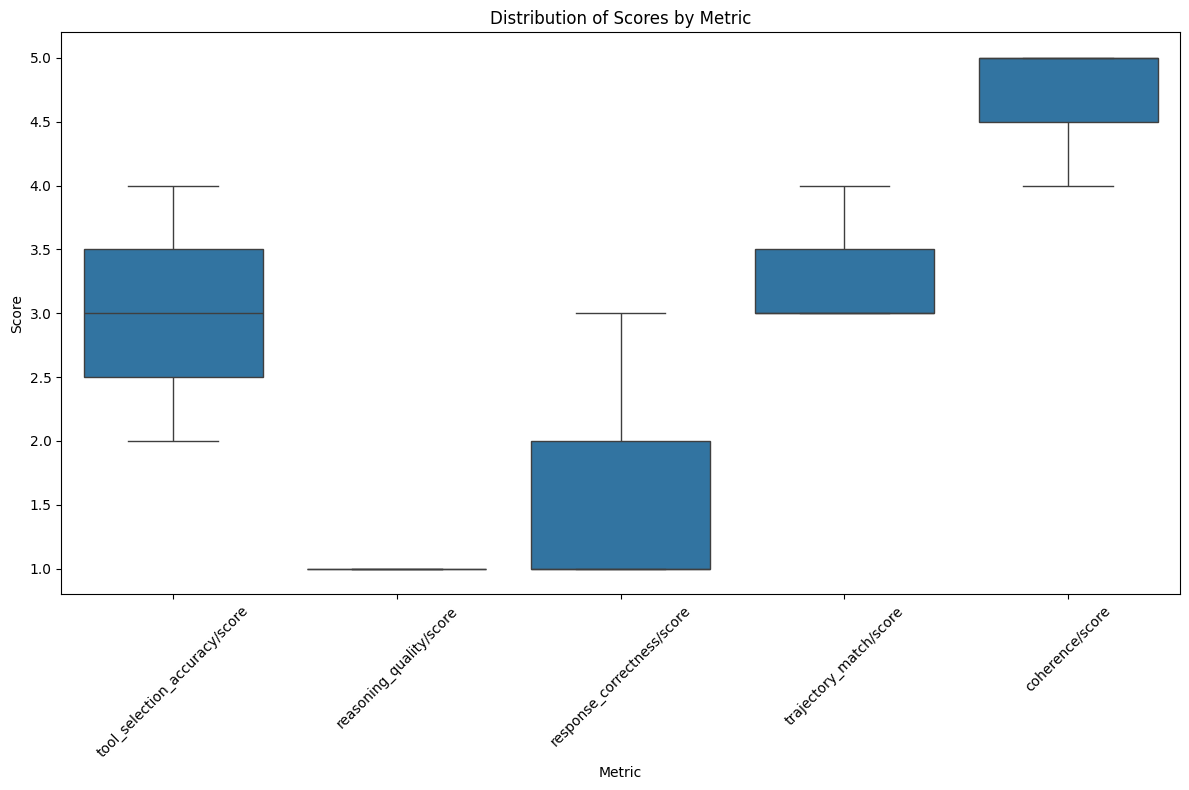

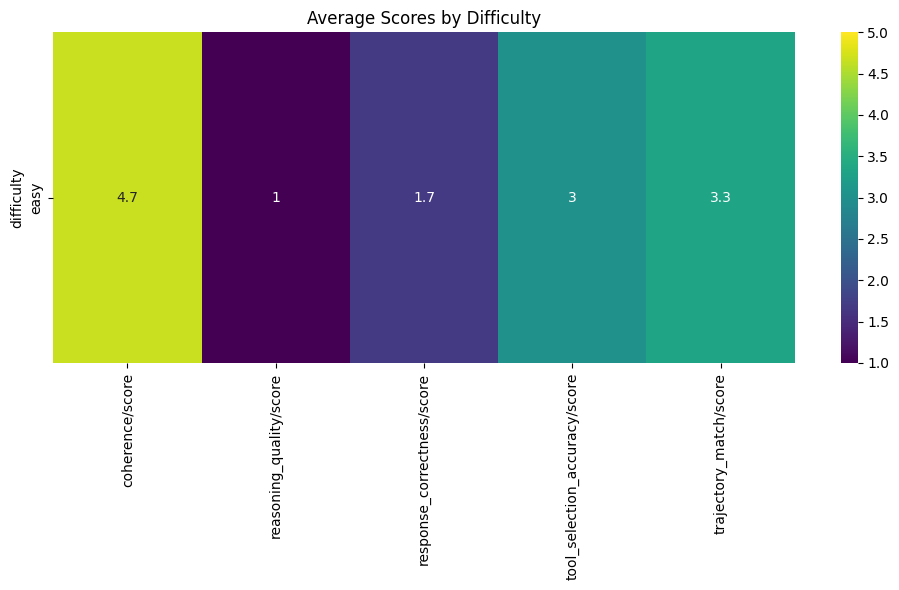

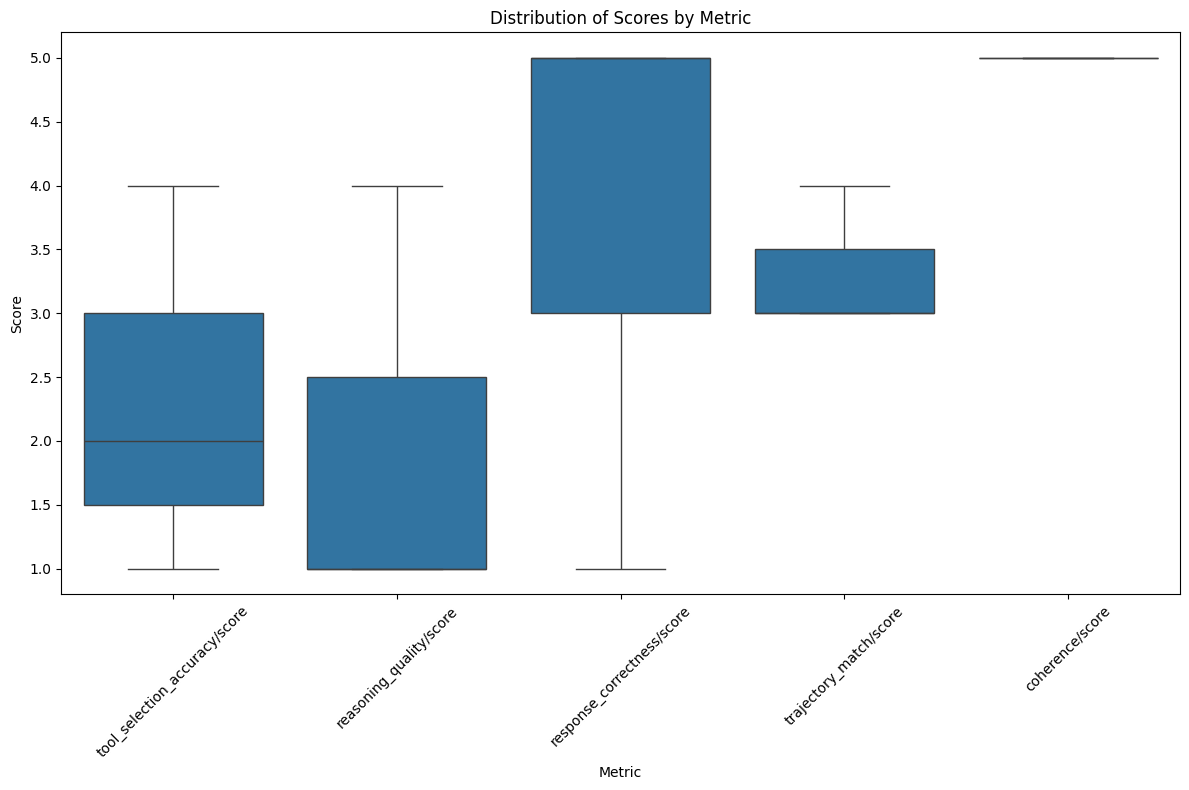

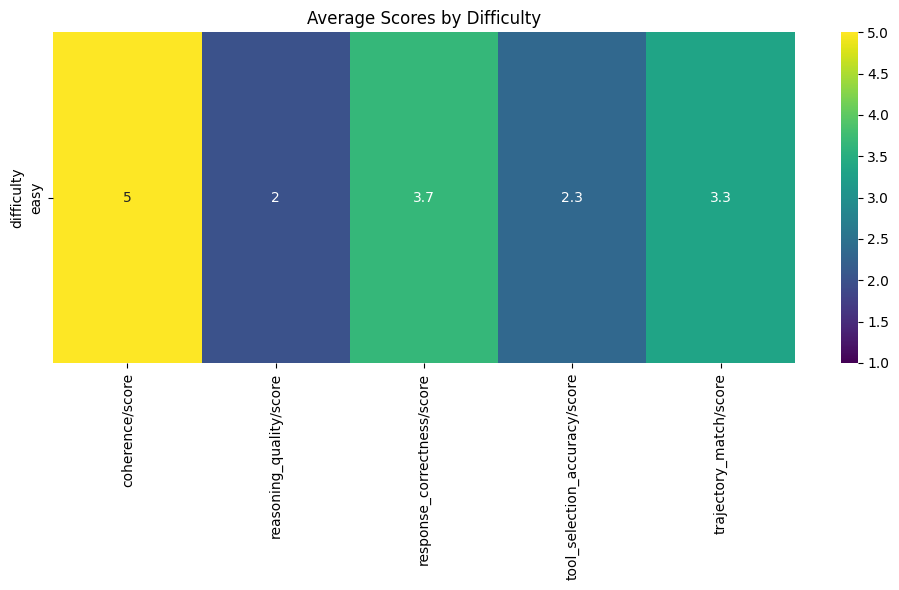

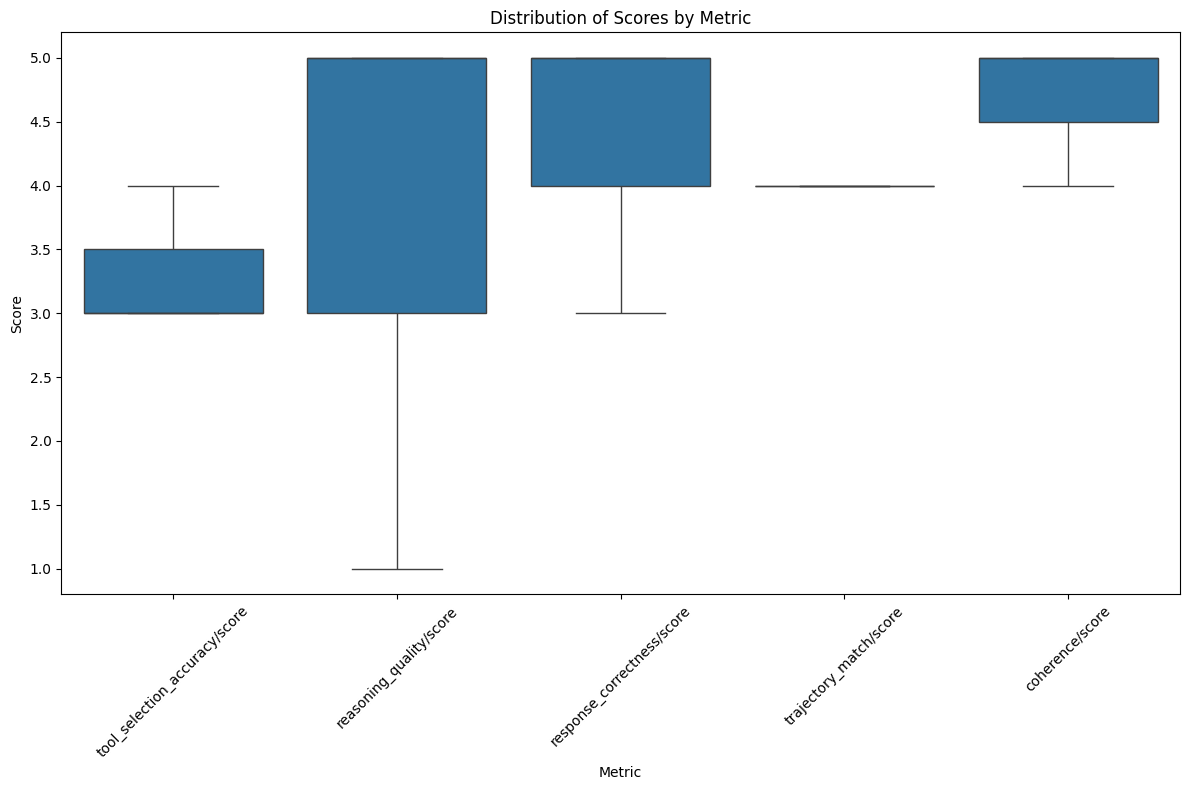

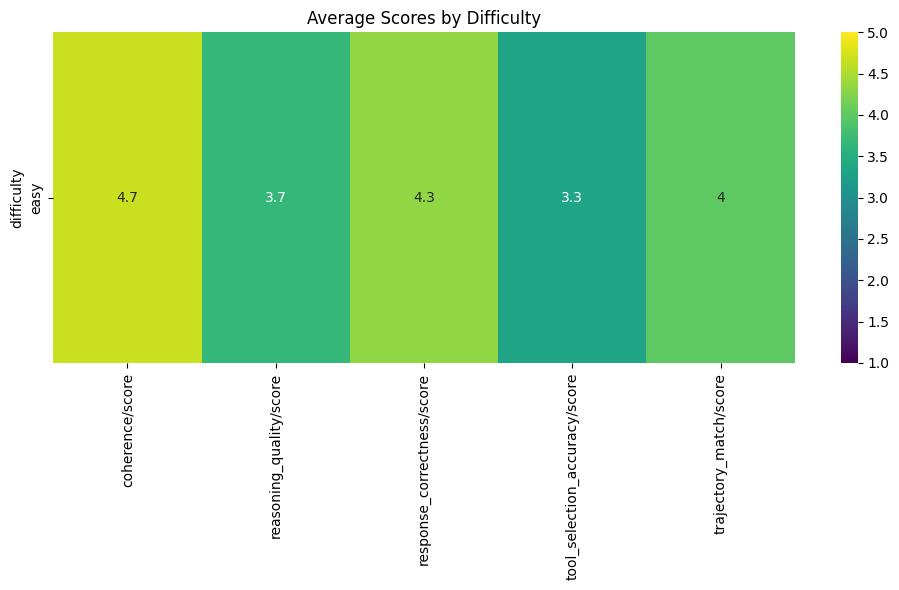

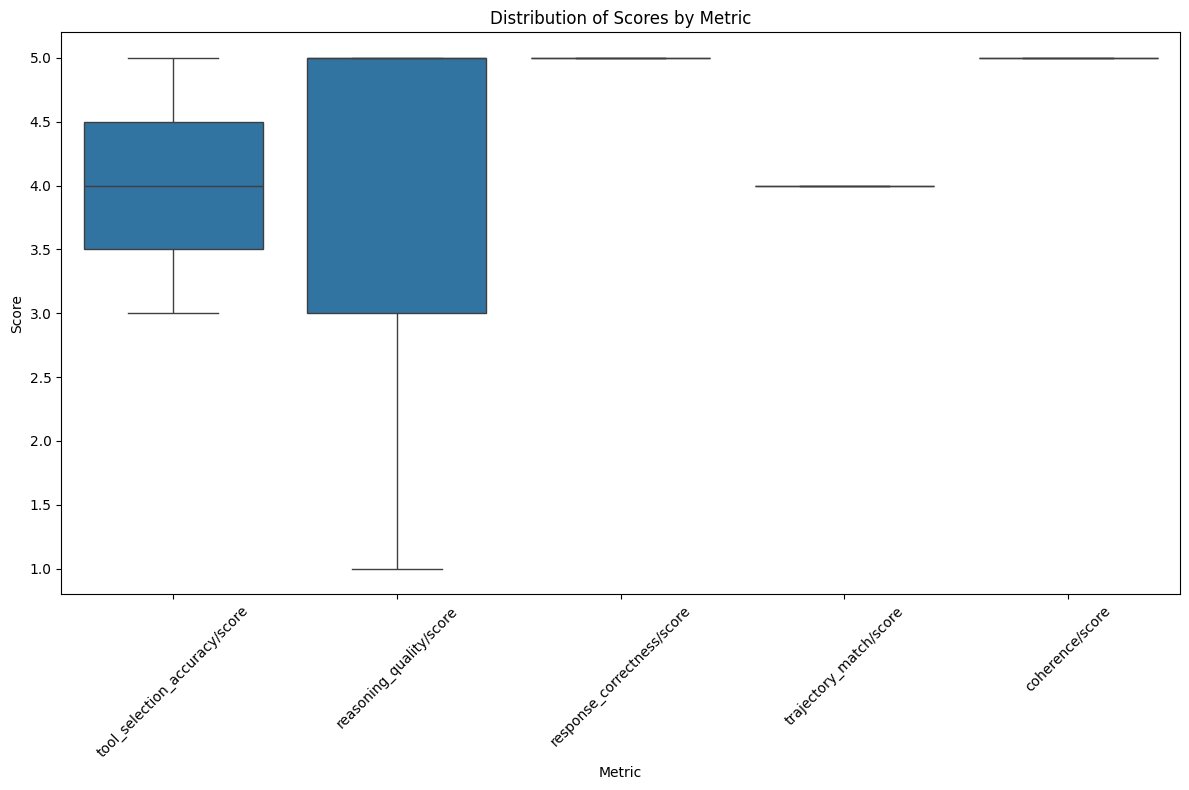

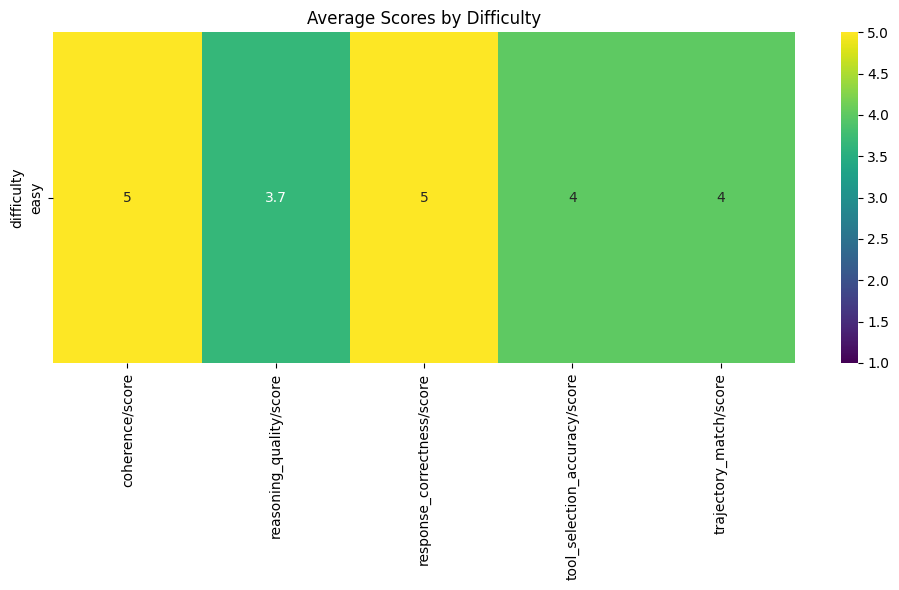

In [9]:
@weave.op()
def evaluate_model_config(
    config: dict[str, Any], eval_dataset: list[dict[str, Any]]
) -> dict[str, Any]:
    """Evaluate a specific model configuration and return results"""
    console.print(f"\n[bold blue]Evaluating {config['name']}...[/bold blue]")

    # Create agent with this configuration
    agent = create_customer_support_agent(
        use_weave=True,
        model_id=config["model_id"],
        temperature=config["temperature"],
        planning_interval=config.get("planning_interval", 1),
        max_steps=config.get("max_steps", 5),
    )

    # Run evaluation with the agent object directly
    results = evaluator.run_evaluation(
        agent=agent,
        eval_dataset=eval_dataset,
        output_dir=f"evaluation_results/{config['name'].replace(' ', '_').lower()}",
        weave_project=WEAVE_PROJECT_NAME,
    )

    # Add configuration details to results
    results["config"] = config

    return results


# Run evaluations for all configurations
all_results = []
for config in model_configs:
    results = evaluate_model_config(config, eval_dataset)
    all_results.append(results)

    # Display summary results
    console.print(f"\n[bold green]Results for {config['name']}:[/bold green]")
    if "summary_metrics" in results and results["summary_metrics"]:
        table = evaluator._render_summary_table(results["summary_metrics"])
        console.print(table)
    else:
        console.print("[yellow]No summary metrics available[/yellow]")

# Navigate to Weave to compare results!!

Go to the project set in `WEAVE_PROJECT_NAME` in `config.py`

# Analyzing Model Performance Patterns

After running evaluations on different model configurations, we analyze the results to uncover key patterns and insights.

## Response Quality by Model Type

We compare how Gemini Pro and Gemini Flash Lite perform on response quality metrics. The analysis reveals which model provides more accurate and helpful customer support responses across our test cases.

## Impact of Temperature Settings

By examining how temperature affects performance, we can determine whether lower temperatures (0.2) produce more consistent, reliable responses or if higher temperatures (0.7) generate more helpful, creative solutions for customer queries.

## Performance Across Query Difficulty

We analyze how different models handle queries of varying complexity:
- Which model excels at simple, straightforward questions?
- Which configuration best handles complex, multi-part customer issues?
- Are there specific difficulty levels where one model significantly outperforms others?


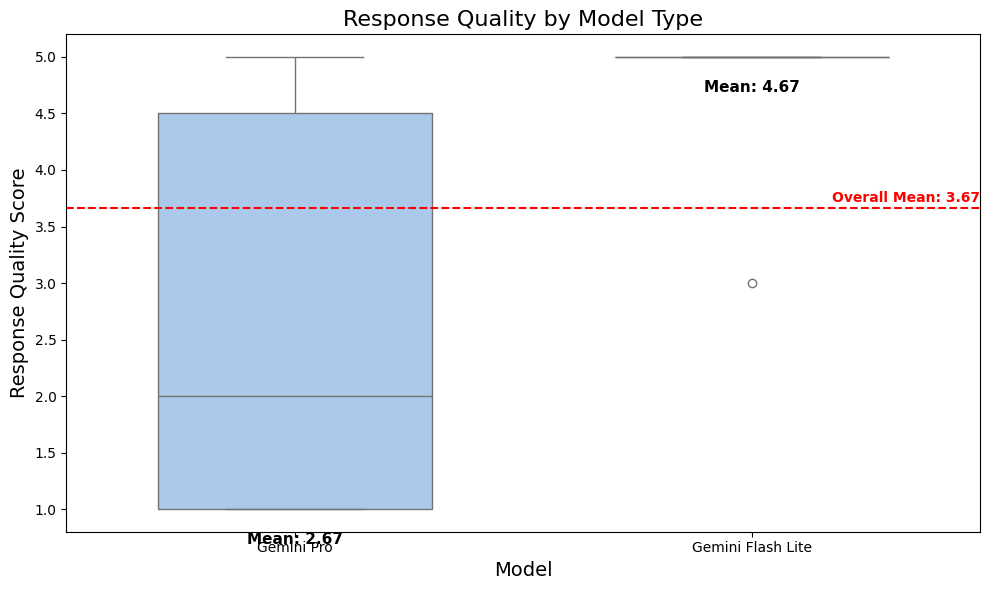

──────────────────────────────────────────── Model Performance Summary ────────────────────────────────────────────

                                             All Metrics by Model Type                                             
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃                  ┃                 ┃ Reasoning        ┃ Response         ┃ Tool Selection    ┃ Trajectory       ┃
┃ Model            ┃ Coherence/Score ┃ Quality/Score    ┃ Correctness/Sco… ┃ Accuracy/Score    ┃ Match/Score      ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ Gemini Pro       │ 4.83            │ 1.50             │ 2.67             │ 2.67              │ 3.33             │
│ Gemini Flash     │ 4.83            │ 3.67             │ 4.67             │ 3.67              │ 4.00             │
│ Lite             │                 │                  │                  │                   │                  │
└──────────────────┴─────────────────┴──────────────────┴──────────────────┴───────────────────┴──────────────────┘

In [10]:
render_model_comparison(all_results, console=console)

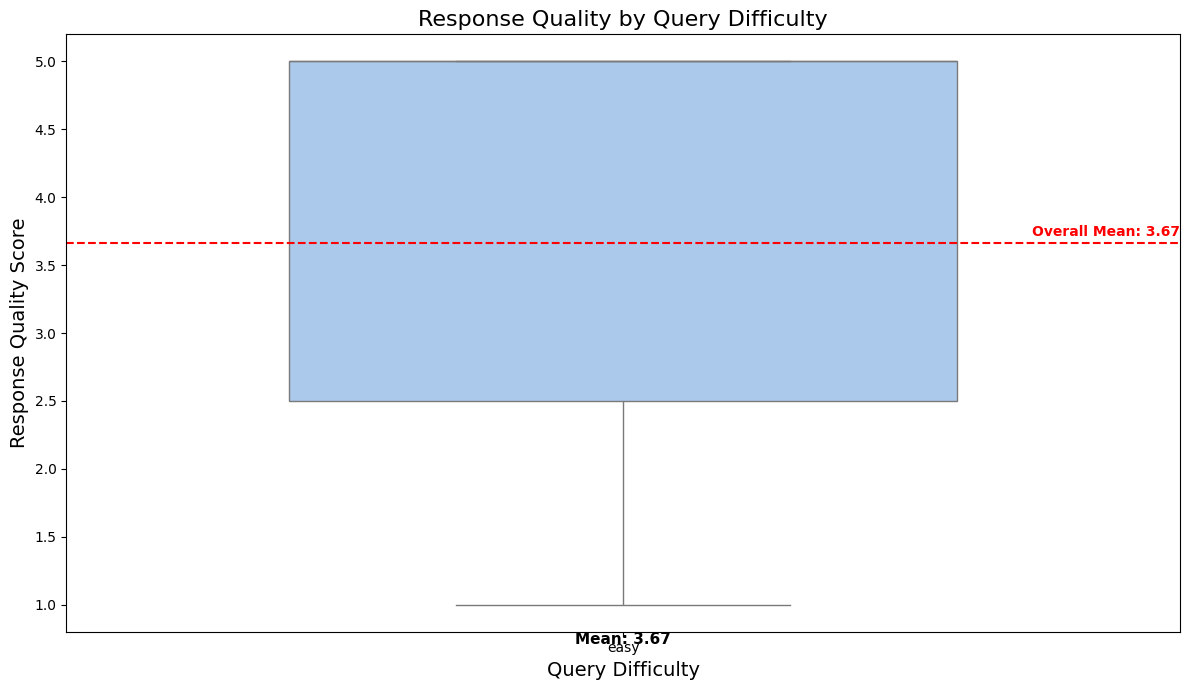

───────────────────────────────────── Best Model Configuration by Difficulty ──────────────────────────────────────

              Best Model Configuration for Each Difficulty Level               
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Difficulty ┃ Best Model        ┃ Temperature ┃ Score ┃ Improvement Over Avg ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ easy       │ Gemini Flash Lite │ 0.7         │ 5.00  │ +1.33 (36.4%)        │
└────────────┴───────────────────┴─────────────┴───────┴──────────────────────┘

──────────────────────────────────────────── All Metrics by Difficulty ────────────────────────────────────────────

                                          All Metrics by Difficulty Level                                          
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃            ┃                 ┃ Reasoning          ┃ Response           ┃ Tool Selection     ┃ Trajectory        ┃
┃ Difficulty ┃ Coherence/Score ┃ Quality/Score      ┃ Correctness/Score  ┃ Accuracy/Score     ┃ Match/Score       ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ easy       │ 4.83            │ 2.58               │ 3.67               │ 3.17               │ 3.67              │
└────────────┴─────────────────┴────────────────────┴────────────────────┴────────────────────┴───────────────────┘

In [11]:
render_difficulty_analysis(all_results, console=console)

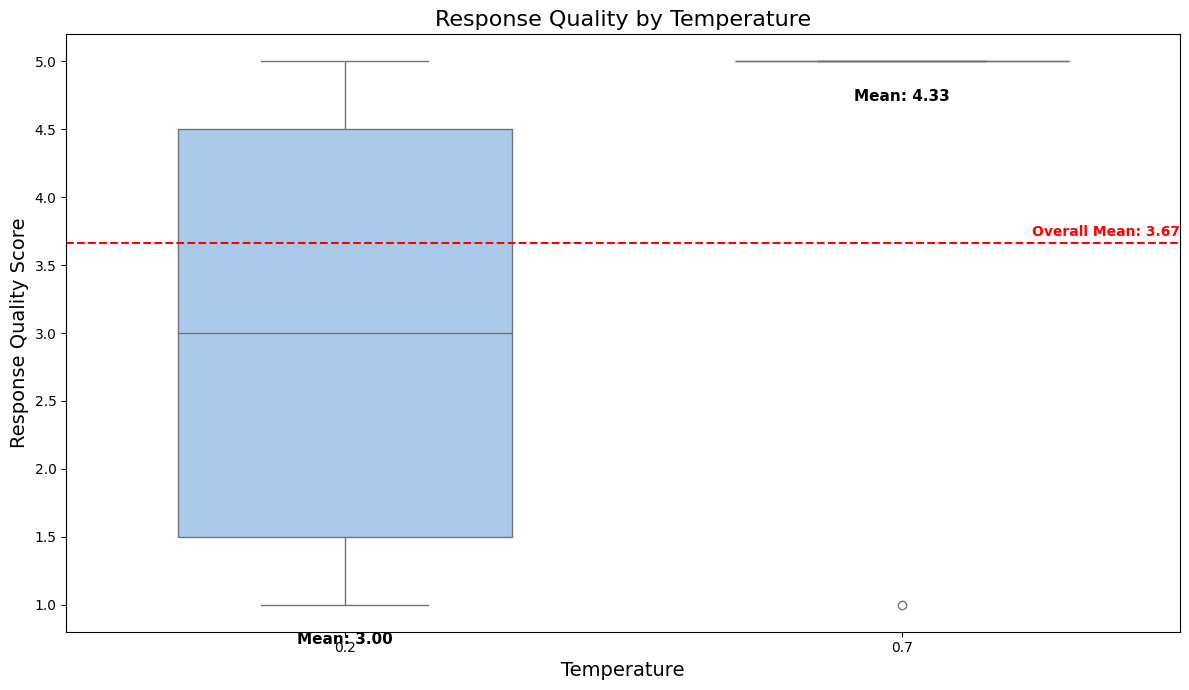

───────────────────────────────────── Best Model Configuration by Temperature ─────────────────────────────────────

          Best Model Configuration for Each Temperature           
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Temperature ┃ Best Model        ┃ Score ┃ Improvement Over Avg ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 0.2         │ Gemini Flash Lite │ 4.33  │ +1.33 (44.4%)        │
│ 0.7         │ Gemini Flash Lite │ 5.00  │ +0.67 (15.4%)        │
└─────────────┴───────────────────┴───────┴──────────────────────┘

─────────────────────────────────────────── All Metrics by Temperature ────────────────────────────────────────────

                                            All Metrics by Temperature                                             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃             ┃                 ┃ Reasoning          ┃ Response          ┃ Tool Selection     ┃ Trajectory        ┃
┃ Temperature ┃ Coherence/Score ┃ Quality/Score      ┃ Correctness/Score ┃ Accuracy/Score     ┃ Match/Score       ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 0.2         │ 4.67            │ 2.33               │ 3.00              │ 3.17               │ 3.67              │
│ 0.7         │ 5.00            │ 2.83               │ 4.33              │ 3.17               │ 3.67              │
└─────────────┴─────────────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

In [12]:
render_temperature_analysis(all_results, console=console)

# Conclusion

Our systematic evaluation of different model configurations provides a framework for making data-driven decisions about customer support agent implementation.

## Next Steps

With the evaluation results in hand, we can now:

1. **Select the optimal configuration** based on actual performance metrics rather than assumptions or theoretical capabilities.

2. **Understand trade-offs** between different models (Gemini Pro vs. Flash Lite) and temperature settings (0.2 vs. 0.7) for our specific customer support scenarios.

3. **Identify improvement areas** by focusing on the metrics where even our best configuration underperformed.

4. **Expand our evaluation dataset** to include more diverse customer queries and edge cases.

This evaluation framework allows us to continually refine our customer support agent as new models become available or as customer needs evolve. By measuring performance objectively across multiple dimensions, we can ensure we're deploying the most effective solution for our specific use case.


In [13]:
render_conclusion(all_results, console=console)

─────────────────────────────────────────────── Evaluation Summary ────────────────────────────────────────────────

                                  Evaluation Summary                                   
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━┓
┃ Metric                        ┃ Best Model                    ┃ Score ┃ Temperature ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━┩
│ Tool Selection Accuracy/Score │ Gemini Flash Lite (High Temp) │ 4.00  │ 0.7         │
│ Reasoning Quality/Score       │ Gemini Flash Lite (Low Temp)  │ 3.67  │ 0.2         │
│ Response Correctness/Score    │ Gemini Flash Lite (High Temp) │ 5.00  │ 0.7         │
│ Trajectory Match/Score        │ Gemini Flash Lite (Low Temp)  │ 4.00  │ 0.2         │
│ Coherence/Score               │ Gemini Pro (High Temp)        │ 5.00  │ 0.7         │
└───────────────────────────────┴───────────────────────────────┴───────┴─────────────┘

Key Findings:

1. Overall Performance: Gemini Flash Lite (High Temp) is the best performing model with an average score of 4.33 
across all metrics.

2. Metric-Specific Performance:
   - Best metric: Coherence/Score (avg: 4.83)
   - Most challenging metric: Reasoning Quality/Score (avg: 2.58)

3. Temperature Impact: Temperature 0.7 yielded the best overall performance (avg: 3.80), while temperature 0.2 
performed worst (avg: 3.37).

4. Model-Specific Insights:
   - Tool Selection Accuracy/Score: Gemini Flash Lite (High Temp) excels (4.00), while Gemini Pro (High Temp) 
struggles (2.33).
   - Reasoning Quality/Score: Gemini Flash Lite (Low Temp) excels (3.67), while Gemini Pro (Low Temp) struggles 
(1.00).
   - Response Correctness/Score: Gemini Flash Lite (High Temp) excels (5.00), while Gemini Pro (Low Temp) struggles
(1.67).
   - Trajectory Match/Score: Gemini Flash Lite (Low Temp) excels (4.00), while Gemini Pro (Low Temp) struggles 
(3.33).
   - Coherence/Score: Gemini Pro (High Temp) excels (5.00), while Gemini Pro (Low Temp) struggles (4.67).

Next Steps:

1. Deploy the best-performing model configuration (Gemini Flash Lite (High Temp)) for production use
2. Focus on improving performance in the weakest metric area: Reasoning Quality/Score
3. Conduct further temperature tuning around the optimal value of 0.7
4. Expand the evaluation dataset with more diverse scenarios
5. Implement continuous evaluation to monitor agent performance over time

{'best_model': 'Gemini Flash Lite (High Temp)',
 'best_model_score': 4.333333333333333,
 'best_temperature': np.float64(0.7),
 'strongest_metric': 'Coherence/Score',
 'weakest_metric': 'Reasoning Quality/Score',
 'metric_details': {'Tool Selection Accuracy/Score': {'model': 'Gemini Flash Lite (High Temp)',
   'score': np.float64(4.0),
   'temperature': np.float64(0.7)},
  'Reasoning Quality/Score': {'model': 'Gemini Flash Lite (Low Temp)',
   'score': np.float64(3.6666666666666665),
   'temperature': np.float64(0.2)},
  'Response Correctness/Score': {'model': 'Gemini Flash Lite (High Temp)',
   'score': np.float64(5.0),
   'temperature': np.float64(0.7)},
  'Trajectory Match/Score': {'model': 'Gemini Flash Lite (Low Temp)',
   'score': np.float64(4.0),
   'temperature': np.float64(0.2)},
  'Coherence/Score': {'model': 'Gemini Pro (High Temp)',
   'score': np.float64(5.0),
   'temperature': np.float64(0.7)}}}